<a href="https://www.kaggle.com/code/mohamedaminesaighi/final-ml-project?scriptVersionId=105982071" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Validation Projet Machine Learning

# Imports

In [1]:
import pandas as pd       
import matplotlib as mat
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
import scipy
from scipy.integrate import simpson
#pip install plotly==5.5.0 
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from tabulate import tabulate
#pip install shap
import shap
import warnings
#warnings.filterwarnings('ignore')
#pip install xgboost
import xgboost as xgb
from functools import partial
#pip install optuna
import optuna
pd.set_option('max_column', None)
plt.style.use("ggplot")
sns.set_style('darkgrid')
pd.set_option('max_column', None)
sns.set(font_scale=1)
SEED=42
NSPLITS = 5
SHUFFLE =True

In [2]:
def decile_table(y_true, y_prob, labels=True, round_decimal=3):
    """Generates the Decile Table from labels and probabilities
    
    The Decile Table is creared by first sorting the customers by their predicted 
    probabilities, in decreasing order from highest (closest to one) to 
    lowest (closest to zero). Splitting the customers into equally sized segments, 
    we create groups containing the same numbers of customers, for example, 10 decile 
    groups each containing 10% of the customer base.
    
    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct/actual) target values.
        y_prob (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier/algorithm.
        labels (bool, optional): If True, prints a legend for the abbreviations of
            decile table column names. Defaults to True.
        round_decimal (int, optional): The decimal precision till which the result is 
            needed. Defaults to '3'.
    Returns:
        dt: The dataframe dt (decile-table) with the deciles and related information.
    Example:
        >>> import kds
        >>> from sklearn.datasets import load_iris
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn import tree
        >>> X, y = load_iris(return_X_y=True)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=3)
        >>> clf = tree.DecisionTreeClassifier(max_depth=1,random_state=3)
        >>> clf = clf.fit(X_train, y_train)
        >>> y_prob = clf.predict_proba(X_test)
        >>> kds.metrics.decile_table(y_test, y_prob[:,1])
    """
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    df = pd.DataFrame()
    df['y_true'] = y_true
    df['y_prob'] = y_prob
    # df['decile']=pd.qcut(df['y_prob'], 10, labels=list(np.arange(10,0,-1))) 
    # ValueError: Bin edges must be unique

    df.sort_values('y_prob', ascending=False, inplace=True)
    df['decile'] = np.linspace(1, 11, len(df), False, dtype=int)

    # dt abbreviation for decile_table
    dt = df.groupby('decile').apply(lambda x: pd.Series([
        np.min(x['y_prob']),
        np.max(x['y_prob']),
        np.mean(x['y_prob']),
        np.size(x['y_prob']),
        np.sum(x['y_true']),
        np.size(x['y_true'][x['y_true'] == 0]),
    ],
        index=(["prob_min", "prob_max", "prob_avg",
                "cnt_cust", "cnt_resp", "cnt_non_resp"])
    )).reset_index()

    dt['prob_min']=dt['prob_min'].round(round_decimal)
    dt['prob_max']=dt['prob_max'].round(round_decimal)
    dt['prob_avg']=round(dt['prob_avg'],round_decimal)
    # dt=dt.sort_values(by='decile',ascending=False).reset_index(drop=True)

    tmp = df[['y_true']].sort_values('y_true', ascending=False)
    tmp['decile'] = np.linspace(1, 11, len(tmp), False, dtype=int)

    dt['cnt_resp_rndm'] = np.sum(df['y_true']) / 10
    dt['cnt_resp_wiz'] = tmp.groupby('decile', as_index=False)['y_true'].sum()['y_true']

    dt['resp_rate'] = round(dt['cnt_resp'] * 100 / dt['cnt_cust'], round_decimal)
    dt['cum_cust'] = np.cumsum(dt['cnt_cust'])
    dt['cum_resp'] = np.cumsum(dt['cnt_resp'])
    dt['cum_resp_wiz'] = np.cumsum(dt['cnt_resp_wiz'])
    dt['cum_non_resp'] = np.cumsum(dt['cnt_non_resp'])
    dt['cum_cust_pct'] = round(dt['cum_cust'] * 100 / np.sum(dt['cnt_cust']), round_decimal)
    dt['cum_resp_pct'] = round(dt['cum_resp'] * 100 / np.sum(dt['cnt_resp']), round_decimal)
    dt['cum_resp_pct_wiz'] = round(dt['cum_resp_wiz'] * 100 / np.sum(dt['cnt_resp_wiz']), round_decimal)
    dt['cum_non_resp_pct'] = round(
        dt['cum_non_resp'] * 100 / np.sum(dt['cnt_non_resp']), round_decimal)
    dt['KS'] = round(dt['cum_resp_pct'] - dt['cum_non_resp_pct'], round_decimal)
    dt['lift'] = round(dt['cum_resp_pct'] / dt['cum_cust_pct'], round_decimal)
    if labels is True:
        print_labels()
    return dt[['decile', 'cum_resp_pct', 'cum_resp_pct_wiz']]

In [3]:
def area_ratio(pcg):
    # Area of the model 
    area_model = auc(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct.values))
    # Area of the base model
    area_base = auc(np.append(np.arange(0, 100, 10), 100), np.append(np.arange(0, 10, 1), 10))
    # Area between model and base
    diff_base_model = area_model - area_base
    # Area of the wizard
    area_wizard = auc(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct_wiz.values))
    # Area between wizard and base
    diff_wizard_base = area_wizard - area_base
    # area ratio
    area_ratio = diff_base_model / diff_wizard_base
    return area_ratio

In [4]:
def plot_lift_chart(pcg, area_ratio, title='Cumulative Gain Plot',
                         title_fontsize=14, text_fontsize=10, figsize=None):
    """Generates the cumulative Gain Plot from labels and probabilities
    The cumulative gains chart is used to determine the effectiveness of a
    binary classifier. A detailed explanation can be found at
    http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html 
    The implementation here works only for binary classification.
    
    Args:
        y_true (array-like, shape (n_samples)):
            Ground truth (correct) target values.
        y_prob (array-like, shape (n_samples, n_classes)):
            Prediction probabilities for each class returned by a classifier.
        title (string, optional): Title of the generated plot. Defaults to
            "Decile-wise Lift Plot".
        title_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values (8, 10, 12, etc.)
            Defaults to 14.
        text_fontsize (string or int, optional): Matplotlib-style fontsizes.
            Use e.g. "small", "medium", "large" or integer-values (8, 10, 12, etc.)
            Defaults to 10.
        figsize (2-tuple, optional): Tuple denoting figure size of the plot
            e.g. (6, 6). Defaults to ``None``.
    Returns:
        None
    Example:
        >>> import kds
        >>> from sklearn.datasets import load_iris
        >>> from sklearn.model_selection import train_test_split
        >>> from sklearn import tree
        >>> X, y = load_iris(return_X_y=True)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=3)
        >>> clf = tree.DecisionTreeClassifier(max_depth=1,random_state=3)
        >>> clf = clf.fit(X_train, y_train)
        >>> y_prob = clf.predict_proba(X_test)
        >>> kds.metrics.plot_cumulative_gain(y_test, y_prob[:,1])
    """

    # Cumulative Gains Plot
    # plt.subplot(2, 2, 3)
    plt.plot(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct.values), marker='o', label='Model')
    plt.plot(np.append(0, pcg.decile.values), np.append(0, pcg.cum_resp_pct_wiz.values), 'c--', label='Wizard')
    # plt.plot(list(np.arange(1,11)), np.ones(10), 'k--',marker='o')
    plt.plot([0, 10], [0, 100], 'k--', marker='o', label='Random')
    plt.text(4, 30, f"Area ratio: {area_ratio}")
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel('Deciles', fontsize=text_fontsize)
    plt.ylabel('% Resonders', fontsize=text_fontsize)
    plt.legend(borderpad=1)
    plt.grid(True)

# I. Business understanding:
##### Expliquer les éléments métiers et problématiques à résoudre

### The business understanding phase relies on 4 main steps:

## Business objectives:

## Assess situation:

## Determine data mining goals:

## Produce project plan:

# II. Data understanding

##### Déterminer précisément les données à analyser, à identifier la qualité des données disponibles. 

In [5]:
df= pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')

In [6]:
df.drop(['ID'],axis=1, inplace=True)

In [7]:
df.rename(columns={'PAY_0' : 'PAY_1', 'default.payment.next.month' : 'Default'}, inplace=True)

In [8]:
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(0,5)
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(6,5)
df.loc[:,'EDUCATION'] = df.loc[:,'EDUCATION'].replace(5,4)

In [9]:
data = df.copy()

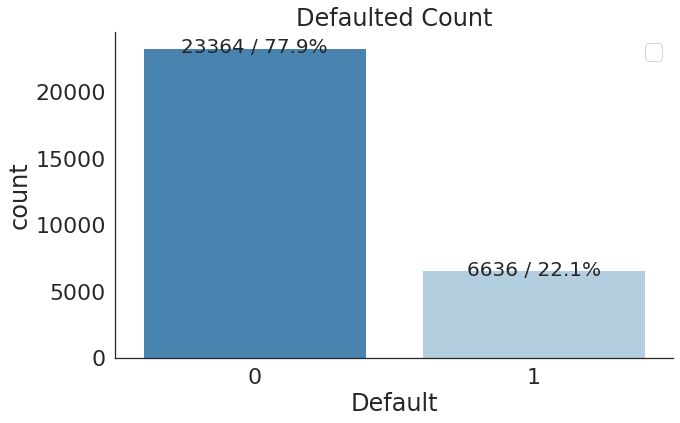

In [10]:
sns.set(font_scale=1)
total_cnt = df['Default'].count()
rcParams['figure.figsize'] = 10,6
sns.set(font_scale= 2)
sns.set_style("white")
ax = sns.countplot(x="Default" , data=df, palette = 'Blues_r')
ax.set_title('Defaulted Count')
plt.legend(loc = 'upper right')
for p in ax.patches:
    x, height , width = p.get_x() , p.get_height() , p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)

sns.despine()

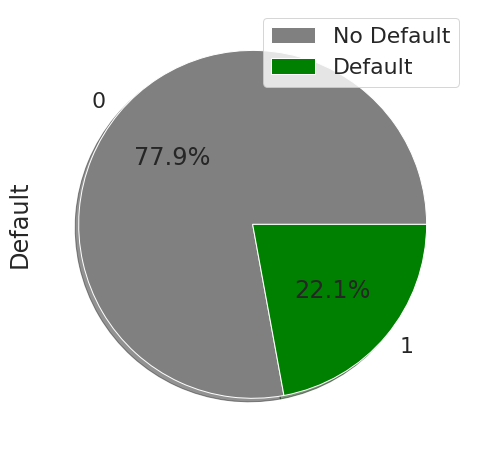

In [11]:
sns.set(font_scale=1)
total_cnt = df['Default'].count()
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(12,8))
df['Default'].value_counts().plot.pie(autopct = '%1.1f%%', 
                                               shadow = True,
                                               colors = ['grey', 'green'])
plt.legend(labels=['No Default', 'Default'])
plt.show()

## Feature : Sex

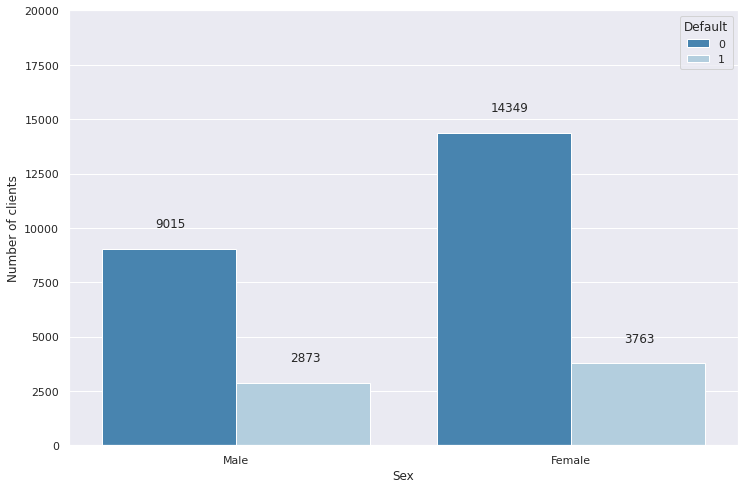

In [12]:
sns.set(font_scale=1)
plt.figure(figsize=(12,8))
ax = sns.countplot(x='SEX' ,hue="Default", data=df,  palette = 'Blues_r')
plt.xlabel('Sex')
plt.ylabel('Number of clients')
plt.ylim(0,20000)
plt.xticks([0,1], ['Male', 'Female'])
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.16, p.get_height()+1000))
    #print(p.get_height())
    #print(p.get_x()+0.16, p.get_height()+1000)
plt.show()

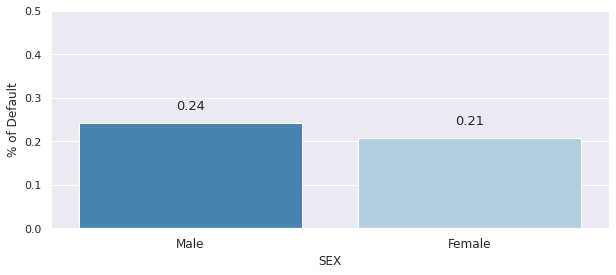

In [13]:
sns.set(font_scale=1)
plt.figure(figsize=(10,4))
ax = sns.barplot(x="SEX", y="Default", data=df,palette = 'Blues_r' ,ci=None)
plt.ylabel("% of Default", fontsize=12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.35, p.get_height()+0.03),fontsize=13)
plt.show()

## Feature : Education

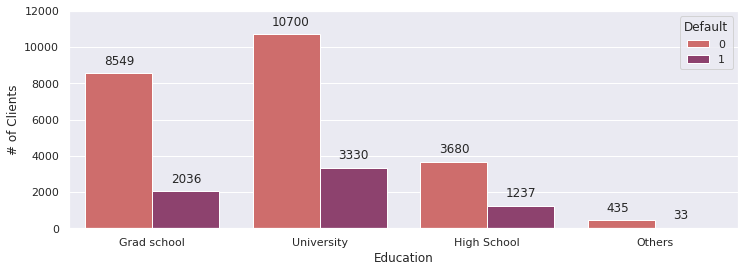

In [14]:
sns.set(font_scale=1)
plt.figure(figsize=(12,4))
ax = sns.countplot(data=df , x='EDUCATION', hue="Default",palette = 'flare' )
plt.xlabel("Education", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,12000)
plt.xticks([0,1,2,3],['Grad school', 'University', 'High School','Others'])
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.11, p.get_height()+500))

plt.show()

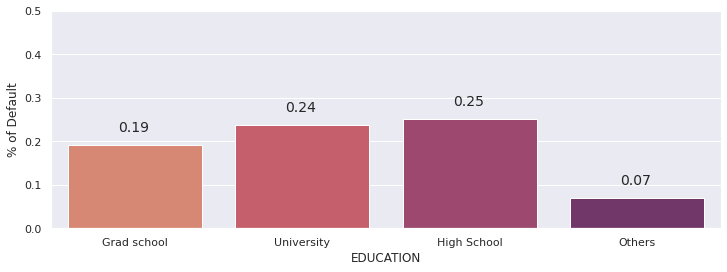

In [15]:
sns.set(font_scale=1)
plt.figure(figsize=(12,4))
ax = sns.barplot(data=df , x='EDUCATION', y="Default",palette = 'flare' , ci=None)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1,2,3],['Grad school', 'University', 'High School','Others'],fontsize=11)
for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.30, p.get_height()+0.03), fontsize=14)

plt.show()

## Feature : Marriage

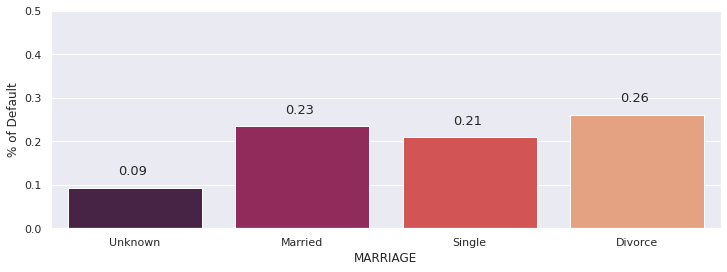

In [16]:
plt.figure(figsize=(12,4))
sns.set(font_scale=1)
ax = sns.barplot(x = "MARRIAGE", y = "Default", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.30, p.get_height()+0.03),fontsize=13)

plt.show()

###### Most people fall on 'married' or 'single' category
###### Unknown category present a lower probability of default

###### Comparing male/female 
###### considering a similar education level and status('married' or 'single')

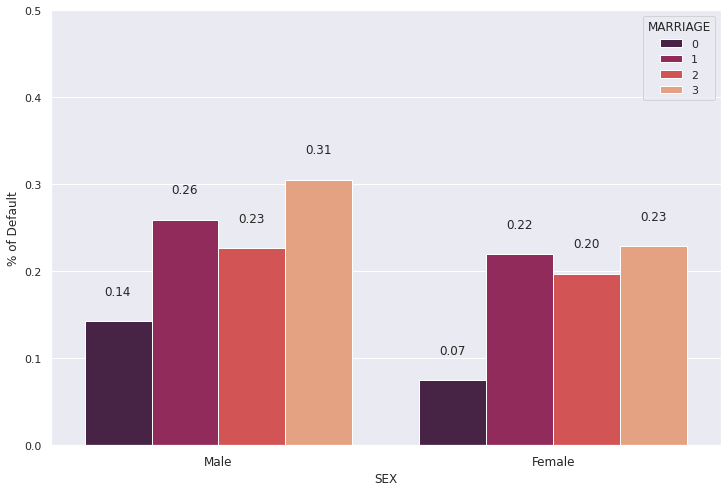

In [17]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
ax = sns.barplot(x = "SEX", y = "Default", hue = "MARRIAGE", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.06, p.get_height()+0.03),fontsize=12)

plt.show()

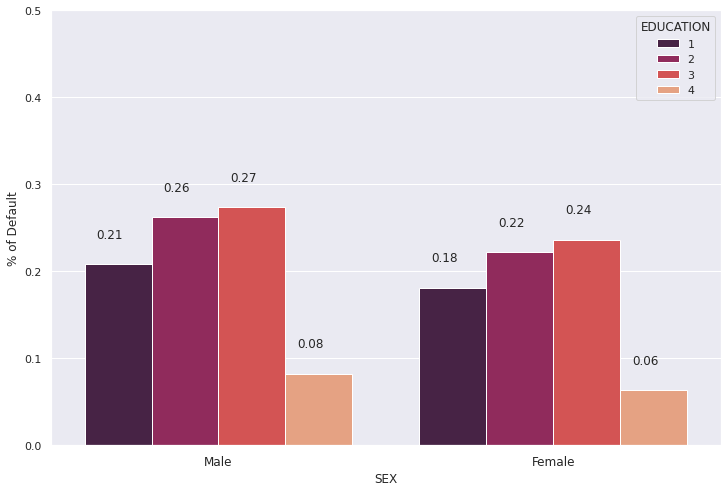

In [18]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
ax = sns.barplot(x = "SEX", y = "Default", hue = "EDUCATION", data = df, palette = 'rocket', ci = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.035, p.get_height()+0.03),fontsize=12)

plt.show()

###### in every single comparison, the probability was higher for men

## Feature : Age

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


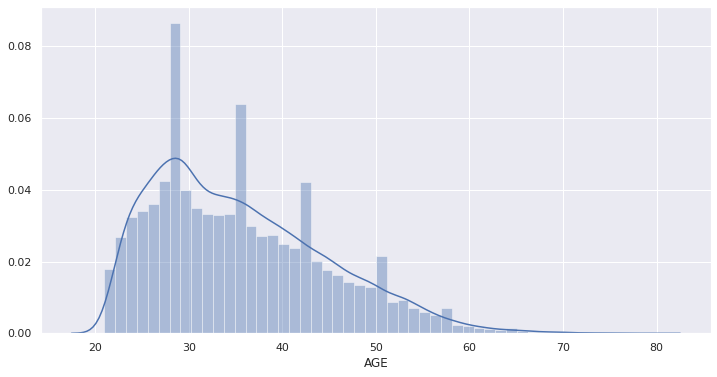

In [19]:
sns.set(font_scale=1)
plt.figure(figsize=(12,6))
sns.distplot(df['AGE'])
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('')
plt.show()

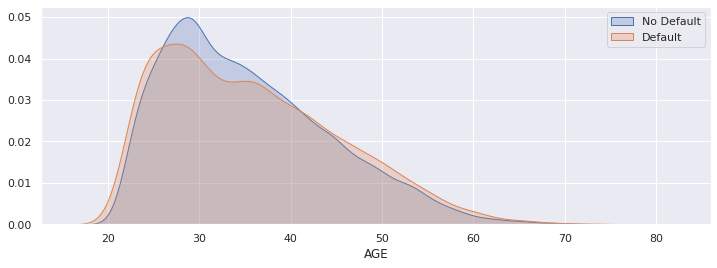

In [20]:
sns.set(font_scale=1)
plt.figure(figsize=(12,4))
sns.kdeplot(df.loc[(df['Default'] == 0), 'AGE'], label='No Default', shade=True) # kernel density estiamtion 
sns.kdeplot(df.loc[(df['Default'] == 1), 'AGE'] ,label='Default', shade=True)
plt.ticklabel_format(style='plain', axis='x') 
plt.ylabel('')
plt.legend()
plt.show()

###### Between the age 25 and 40 the chance of default is a little lower 
###### we could divide our dataset in bins and check the percentage of default in each age group 

In [21]:
df['AgeBin'] = pd.cut(df['AGE'], [20,25,30,35,40,50,60,80])   # bin values into discrete intervals
print(df['AgeBin'].value_counts())

(25, 30]    7142
(40, 50]    6005
(30, 35]    5796
(35, 40]    4917
(20, 25]    3871
(50, 60]    1997
(60, 80]     272
Name: AgeBin, dtype: int64


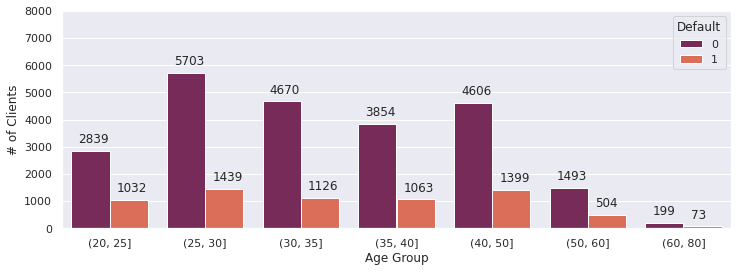

In [22]:
plt.figure(figsize=(12,4))
sns.set(font_scale=1)
df['AgeBin'] = df['AgeBin'].astype('str')
AgeBin_order = ['(20, 25]', '(25, 30]', '(30, 35]', '(35, 40]', '(40, 50]', '(50, 60]', '(60, 80]']

ax = sns.countplot(data = df, x = 'AgeBin', hue="Default", palette = 'rocket', order = AgeBin_order)

plt.xlabel("Age Group", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,8000)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.075, p.get_height()+300))

plt.show()

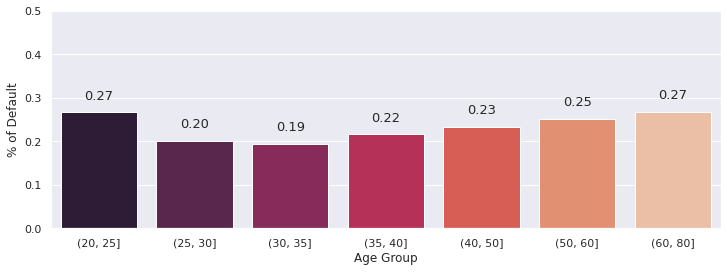

In [23]:
plt.figure(figsize=(12,4))
sns.set(font_scale=1)
ax = sns.barplot(x = 'AgeBin', y="Default", data=df , palette = 'rocket', ci = None, order = AgeBin_order)

plt.xlabel("Age Group", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

###### the lowest chance of default are regestered around [30-35] , while the highest occur at ([20-25] and 60+)

## Feature : Limit_Bal

###### amount of given credit

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


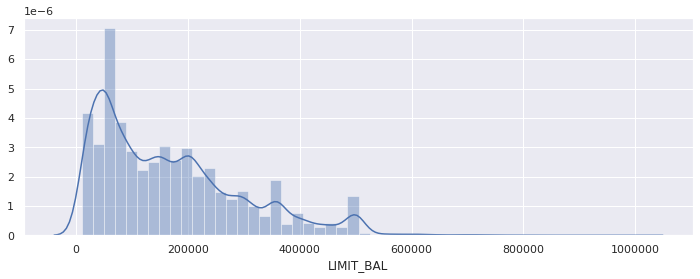

In [24]:
plt.figure(figsize=(12,4))
sns.set(font_scale=1)
sns.distplot(df['LIMIT_BAL'])
plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation on x
plt.ylabel('')
plt.show()

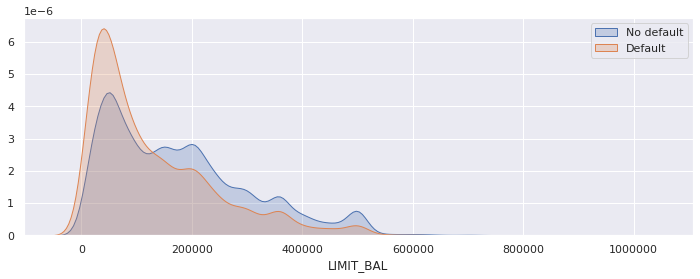

In [25]:
plt.figure(figsize=(12,4)) 
sns.set(font_scale=1)
# kernel density estimation
sns.kdeplot(df.loc[(df['Default'] == 0), 'LIMIT_BAL'], label = 'No default', shade=True)
sns.kdeplot(df.loc[(df['Default'] == 1), 'LIMIT_BAL'], label = 'Default', shade = True)
plt.ticklabel_format(style='plain', axis='x') 
plt.ylabel('')
plt.legend()
plt.show()

###### observation : most customers have 200k or less of credit limit. 
###### A higher concentration of customers in default on that range

In [26]:
df['LimitBin'] = pd.cut(df['LIMIT_BAL'],[5000, 50000, 100000, 150000, 200000, 300000, 400000, 500000, 1100000])

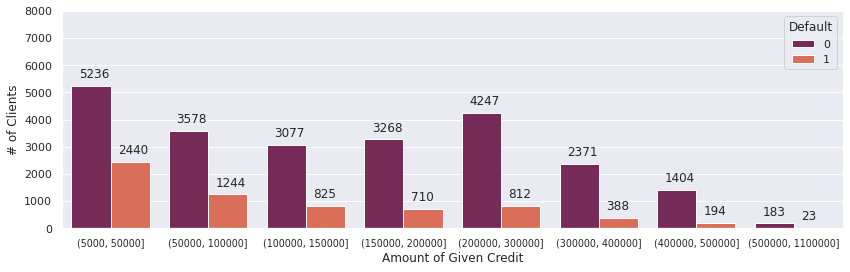

In [27]:
plt.figure(figsize=(14,4))
sns.set(font_scale=1)
df['LimitBin'] = df['LimitBin'].astype('str') # astype() : cast a pandas object to a specified dtype

LimitBin_order = ['(5000, 50000]', '(50000, 100000]', '(100000, 150000]', '(150000, 200000]',
                '(200000, 300000]', '(300000, 400000]', '(400000, 500000]', '(500000, 1100000]']

ax = sns.countplot(data=df, x='LimitBin' , hue="Default", palette = 'rocket', order = LimitBin_order)

plt.xlabel("Amount of Given Credit", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,8000)
ax.tick_params(axis="x", labelsize= 9.5)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.075, p.get_height()+300))
    
plt.show()

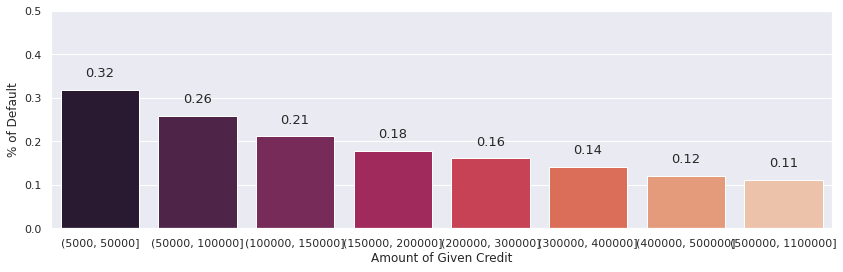

In [28]:
plt.figure(figsize=(14,4))
sns.set(font_scale=1)
ax = sns.barplot(x = "LimitBin", y = "Default", data = df, palette = 'rocket', ci = None, order = LimitBin_order)

 
plt.xlabel("Amount of Given Credit", fontsize= 12)
plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=13)

plt.show()

###### observation : there is a significant rate of default (over 30%) from customers with 50k or less of credit limit
###### => the higher the limit, the lower is the chance of defaulting

## Amount of Given Credit (LIMIT_BAL) + Demographic Features (SEX, EDUCATION , MARRIAGE)

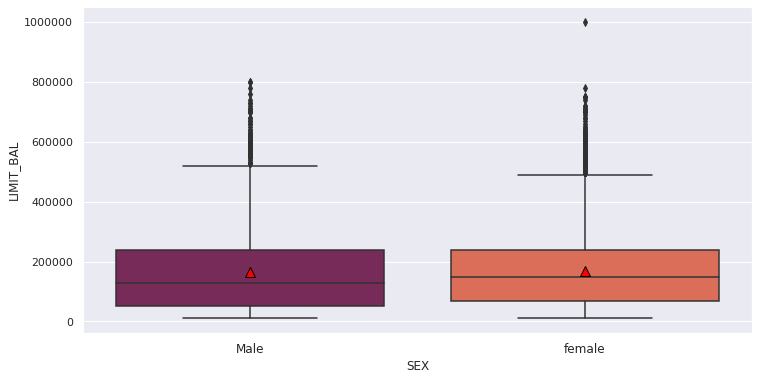

In [29]:
plt.figure(figsize=(12,6))
sns.set(font_scale=1)
sns.boxplot(x="SEX", y="LIMIT_BAL",data=df, palette = 'rocket', showmeans=True, 
           meanprops={"markerfacecolor":"red", "markeredgecolor":"black","markersize":"10"})
plt.ticklabel_format(style='plain', axis='y')
plt.xticks([0,1],['Male','female'], fontsize = 12)
plt.show()

###### seaborn boxplot : (categorical destribution plots) median, bottom quartile(25th percentile) , top quartile(25th percentile) (interquartile range IQR) and whiskers(1.5*IQR)
###### showmeans=True : mean triangle

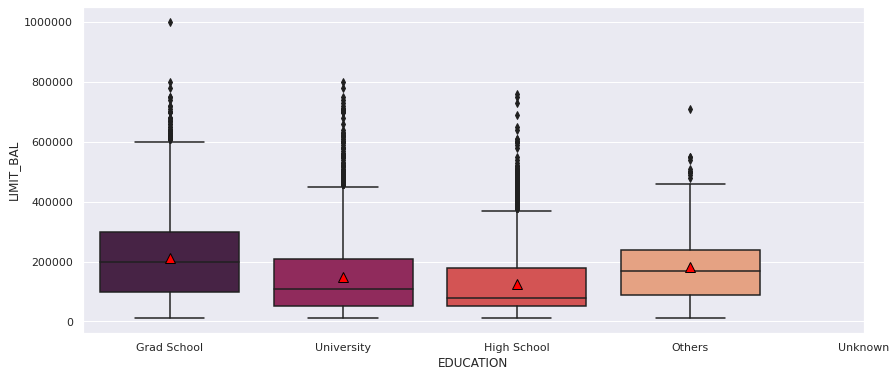

In [30]:
plt.figure(figsize=(14,6))
sns.set(font_scale=1)
sns.boxplot(x = "EDUCATION", y = "LIMIT_BAL", data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation   
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

plt.show()

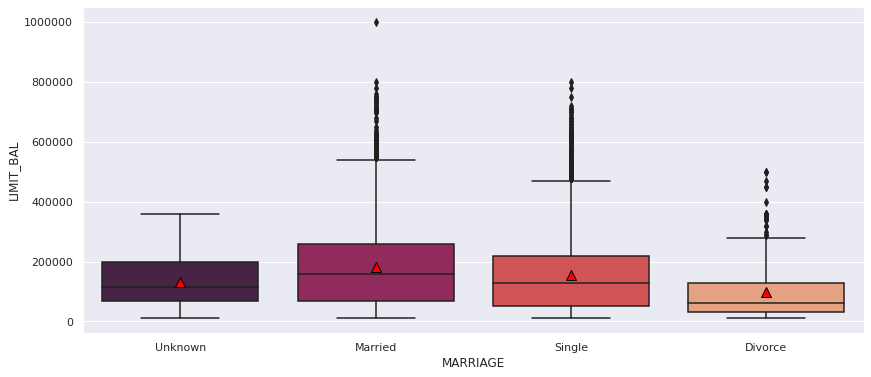

In [31]:
plt.figure(figsize=(14,6))
sns.set(font_scale=1)
sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

plt.show()

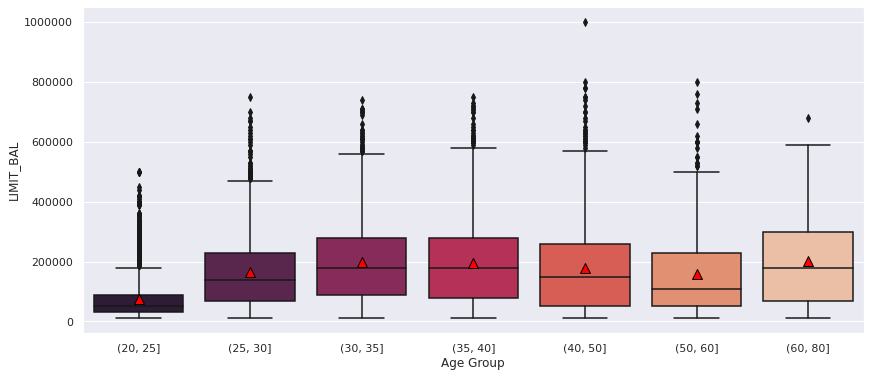

In [32]:
plt.figure(figsize=(14,6))
sns.set(font_scale=1)
sns.boxplot(x = "AgeBin", y = "LIMIT_BAL",data = df, palette = 'rocket', order = AgeBin_order, showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xlabel("Age Group", fontsize= 12)

plt.show()

###### observation :
###### we could analyze the relationship the credit limit and the combination of two demographic features

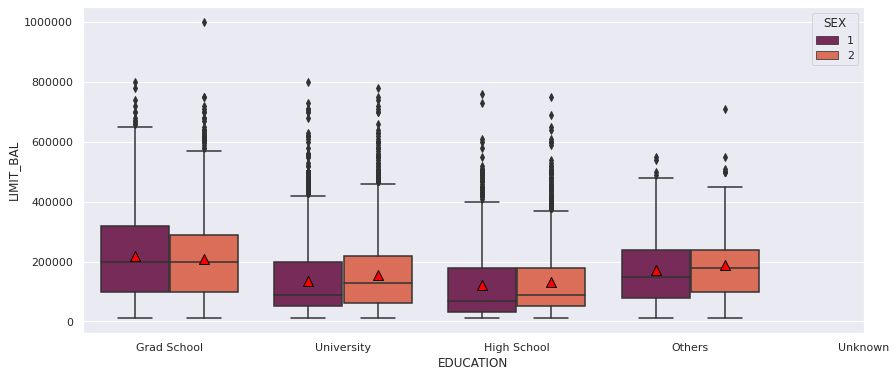

In [33]:
sns.set(font_scale=1)
plt.figure(figsize=(14,6))
sns.boxplot(x="EDUCATION" , y="LIMIT_BAL", hue='SEX',data=df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})
plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation   
plt.xticks([0,1,2,3,4],['Grad School','University','High School','Others','Unknown'], fontsize = 11)

plt.show()

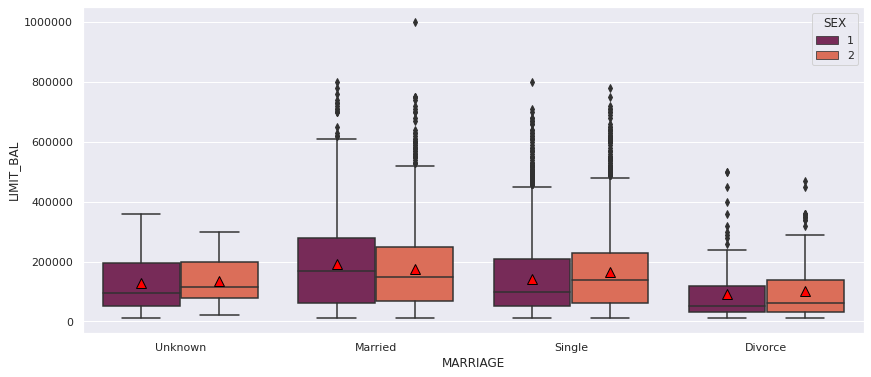

In [34]:
plt.figure(figsize=(14,6))
sns.set(font_scale=1)
sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xticks([0,1,2,3],['Unknown', 'Married', 'Single', 'Divorce'], fontsize = 11)

plt.show()

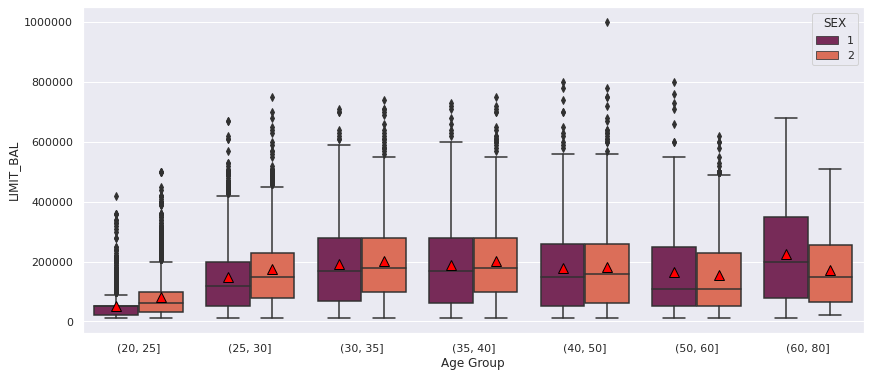

In [35]:
sns.set(font_scale=1)
plt.figure(figsize=(14,6))

sns.boxplot(x = "AgeBin", y = "LIMIT_BAL", hue = 'SEX', data = df, palette = 'rocket', order = AgeBin_order, showmeans=True, 
            meanprops={"markerfacecolor":"red",  "markeredgecolor":"black", "markersize":"10"})

plt.ticklabel_format(style='plain', axis='y') #repressing scientific notation    
plt.xlabel("Age Group", fontsize= 12)

plt.show()

###### we saw earlier that the average given credit for women was slightly higher than for men. that still holds up for several combinations 
###### of categories, except among customers that(have a grad school diploma / are married / are 50+ years old)

## Feature : repayment status (PAY_X) 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

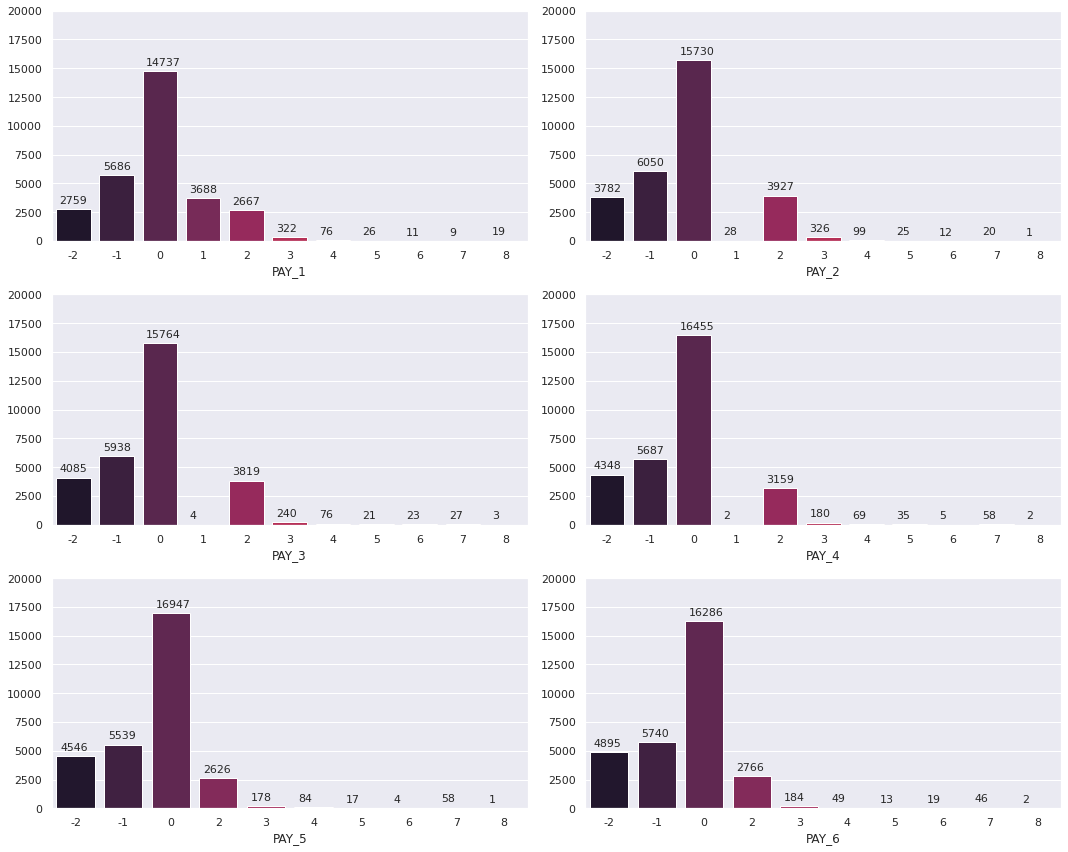

In [36]:
pay_x_fts = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
plt.figure(figsize=(15,12))
sns.set(font_scale=1)
for i,col in enumerate(pay_x_fts):
    plt.subplot(3,2,i+1)
    ax = sns.countplot(df.loc[:,col], palette = 'rocket')
    plt.ylim(0,20000)
    plt.ylabel('')
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate((p.get_height()) , (p.get_x() + 0.08 , p.get_height()+500), fontsize = 11)
plt.show()

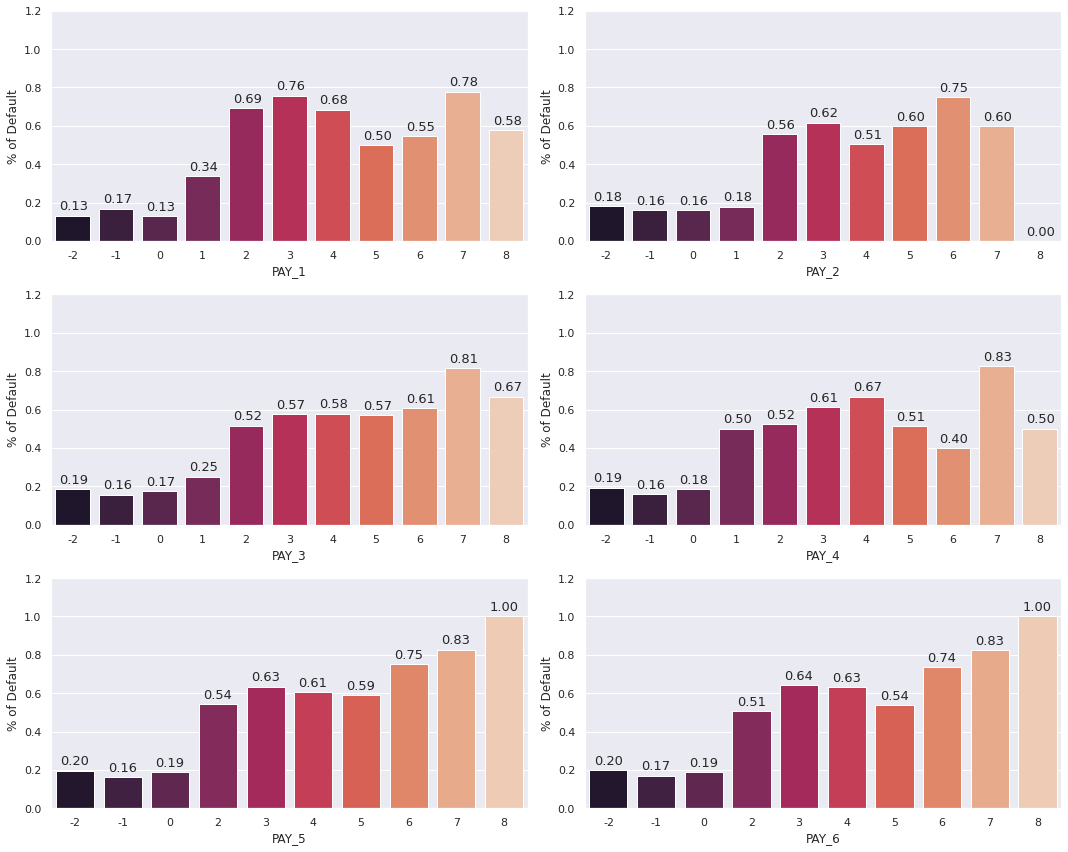

In [37]:
plt.figure(figsize=(15,12))
sns.set(font_scale=1)
for i,col in enumerate(pay_x_fts):
    plt.subplot(3,2,i + 1)
    ax = sns.barplot(x=col, y="Default", data=df, palette = 'rocket', ci = None)
    plt.ylabel("% of Default", fontsize= 12)
    plt.ylim(0,1.2)
    plt.tight_layout()
    
    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.09, p.get_height()+0.03),fontsize=13)

plt.show()

###### observation : Most customers are duly paying their credit card bills. And it's pretty clear that their likelihood of default are much lower than the rest.

###### we'll be following the same approach used to analyze 'Age' and 'Limit_Bal' , showing destribution and density , than dividing data inbins to get a clear
###### percentage of default for each group

## Feature : Amount of Bill Statement (BILL_AMTX)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

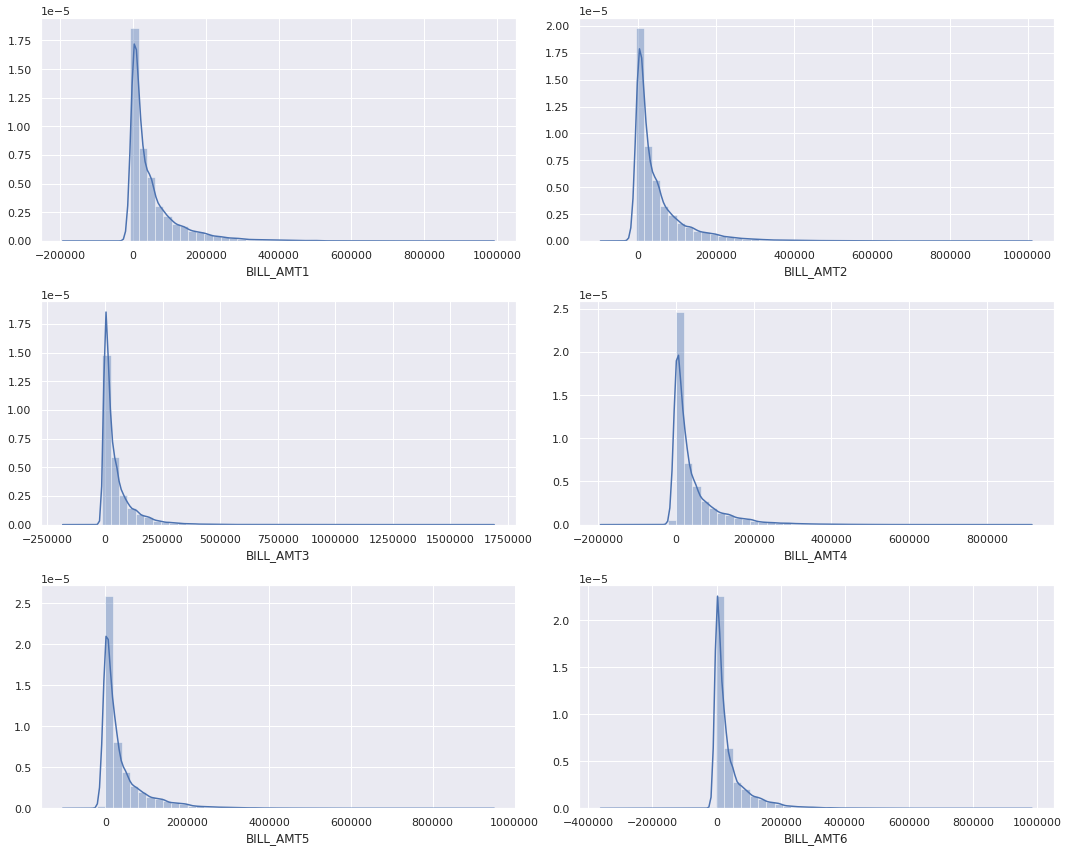

In [38]:
sns.set(font_scale=1)

bill_amtx_fts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
plt.figure(figsize=(15,12))

for i,col in enumerate(bill_amtx_fts):
    plt.subplot(3,2,i+1)
    sns.distplot(df.loc[:,col])
    plt.ticklabel_format(style='plain', axis='x') #repressing scientific notation    
    plt.ylabel('')
    plt.tight_layout()

plt.show()

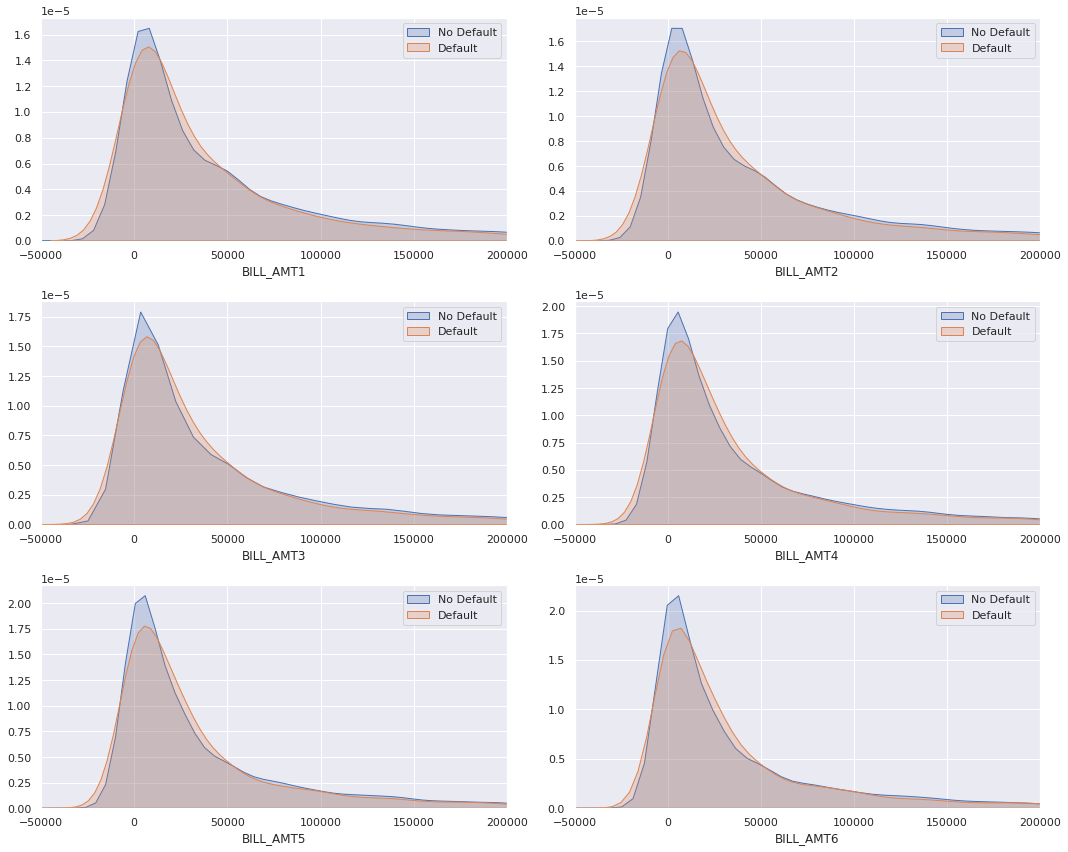

In [39]:
plt.figure(figsize=(15,12))
sns.set(font_scale=1)
for i,col in enumerate(bill_amtx_fts):
    plt.subplot(3,2,i+1)
    sns.kdeplot(df.loc[(df['Default'] == 0), col], label = 'No Default', shade=True)
    sns.kdeplot(df.loc[(df['Default'] == 1), col], label = 'Default', shade = True)
    plt.xlim(-50000,200000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()
plt.show()

In [40]:
df['BILL_AMT1_bin'] = df['BILL_AMT1'].copy()
df['BILL_AMT2_bin'] = df['BILL_AMT2'].copy()
df['BILL_AMT3_bin'] = df['BILL_AMT3'].copy()
df['BILL_AMT4_bin'] = df['BILL_AMT4'].copy()
df['BILL_AMT5_bin'] = df['BILL_AMT5'].copy()
df['BILL_AMT6_bin'] = df['BILL_AMT6'].copy()

In [41]:
bill_amtx_bins = ['BILL_AMT1_bin', 'BILL_AMT2_bin', 'BILL_AMT3_bin', 'BILL_AMT4_bin', 'BILL_AMT5_bin', 'BILL_AMT6_bin']

for i,col in enumerate(bill_amtx_bins):
    df[col] = pd.cut(df[bill_amtx_bins[i]],[-350000,-1,0,25000, 75000, 200000, 2000000] )

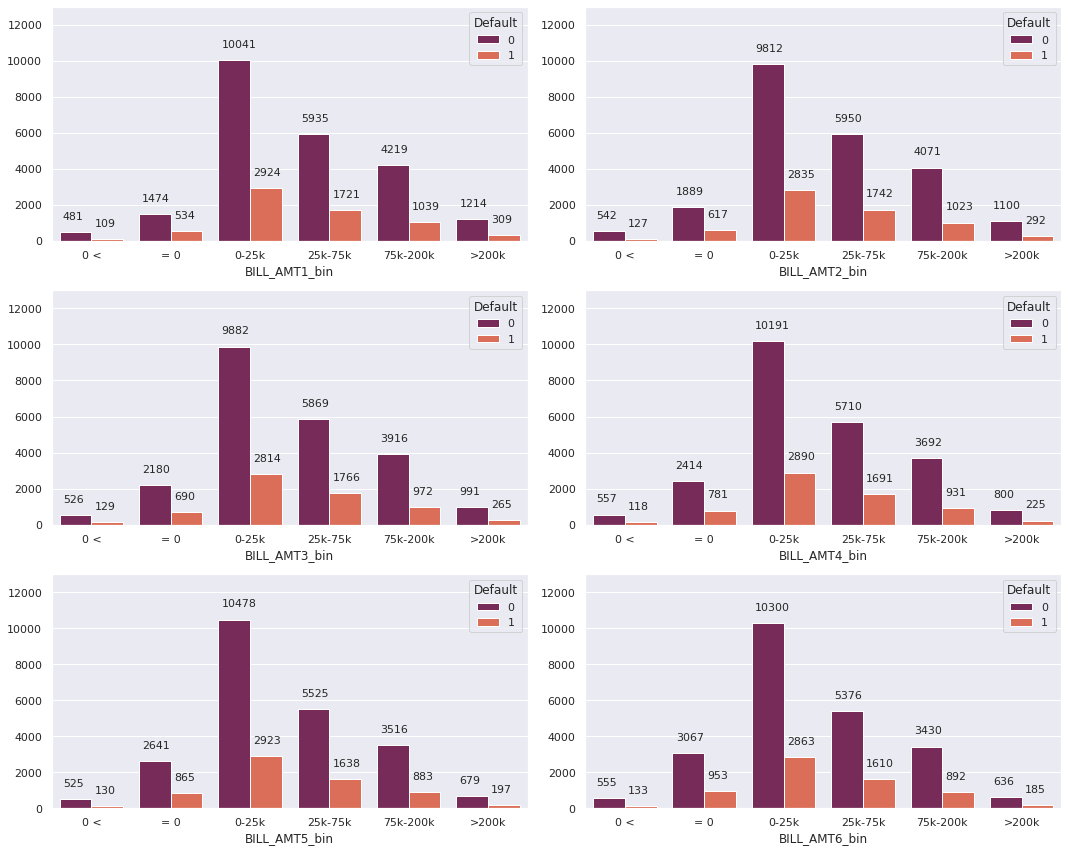

In [42]:
plt.figure(figsize=(15,12))
sns.set(font_scale=1) 
for i,col in enumerate(bill_amtx_bins):    
    plt.subplot(3,2,i + 1)
    ax = sns.countplot(data = df, x = col, hue="Default", palette = 'rocket')
    plt.ylim(0,13000)
    plt.ylabel('')
    plt.xticks([0,1,2,3,4,5],['0 <', '= 0', '0-25k', '25k-75k', '75k-200k', '>200k'], fontsize = 11)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.04, p.get_height()+700), fontsize = 11)    
        
plt.show()

###### observation : those who have a negative bill statement have a lower chance of default than the rest.

## Feature : Amount of Previous Payment (PAY_AMTX)  

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Ple

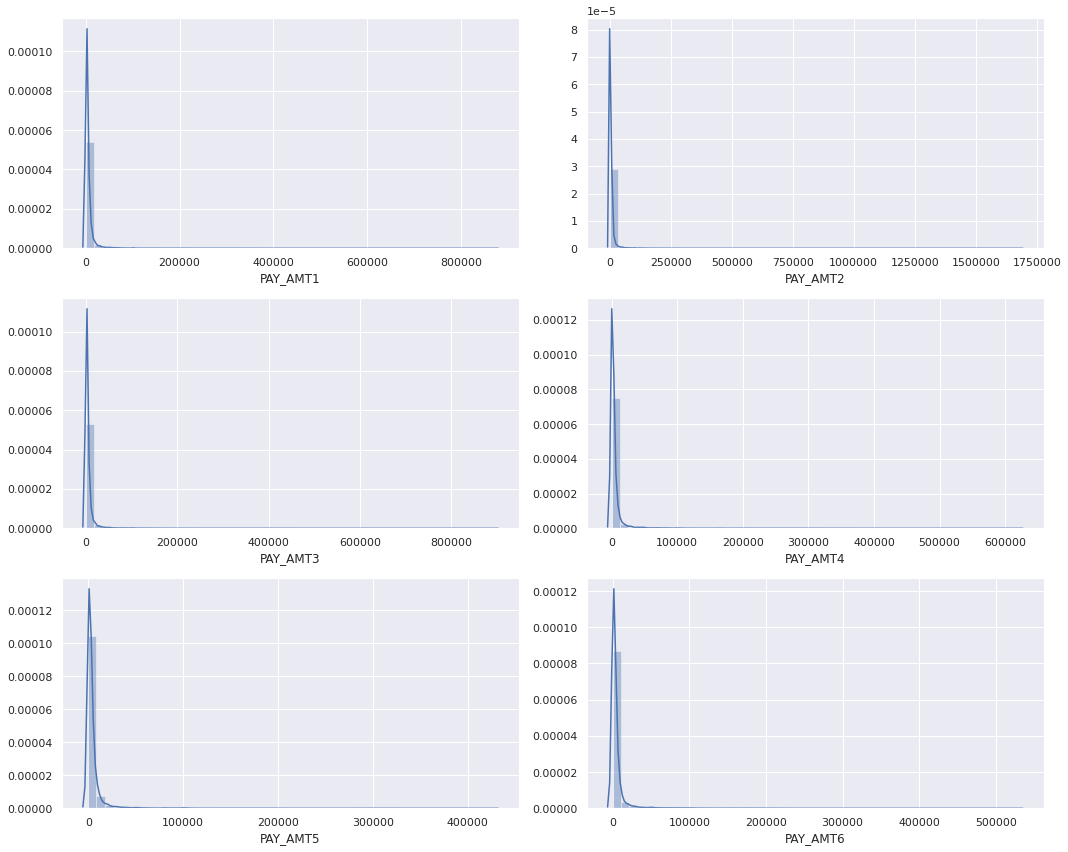

In [43]:
pay_amtx_fts = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
plt.figure(figsize=(15,12))
sns.set(font_scale=1) 


for i,col in enumerate(pay_amtx_fts):
    plt.subplot(3,2,i+1)
    sns.distplot(df.loc[:,col])
    plt.ticklabel_format(style='plain', axis='x') 
    plt.ylabel('')
    plt.tight_layout()

plt.show()

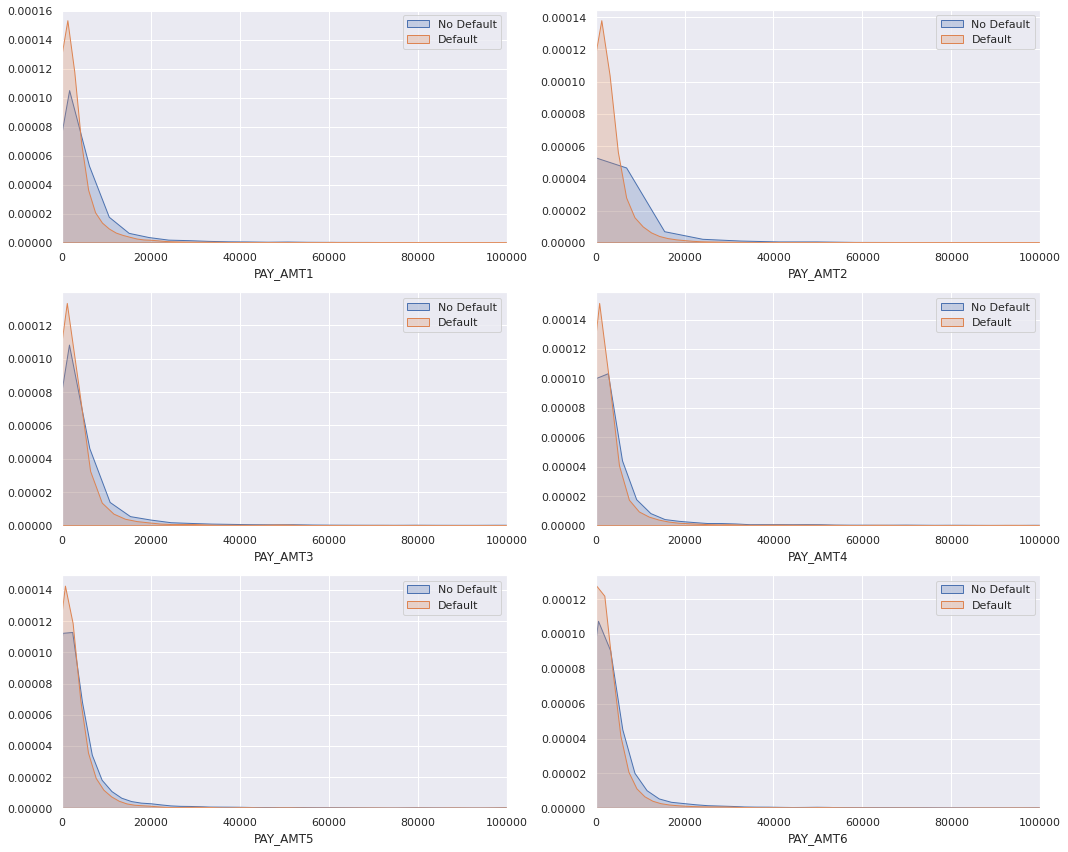

In [44]:
plt.figure(figsize=(15,12))
sns.set(font_scale=1) 


for i,col in enumerate(pay_amtx_fts):
    plt.subplot(3,2,i + 1)   
    sns.kdeplot(df.loc[(df.Default == 0), col ],label  = 'No Default', shade=True )
    sns.kdeplot(df.loc[(df.Default == 1), col ], label  = 'Default', shade = True )
    plt.xlim(0,100000)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout()

plt.show()

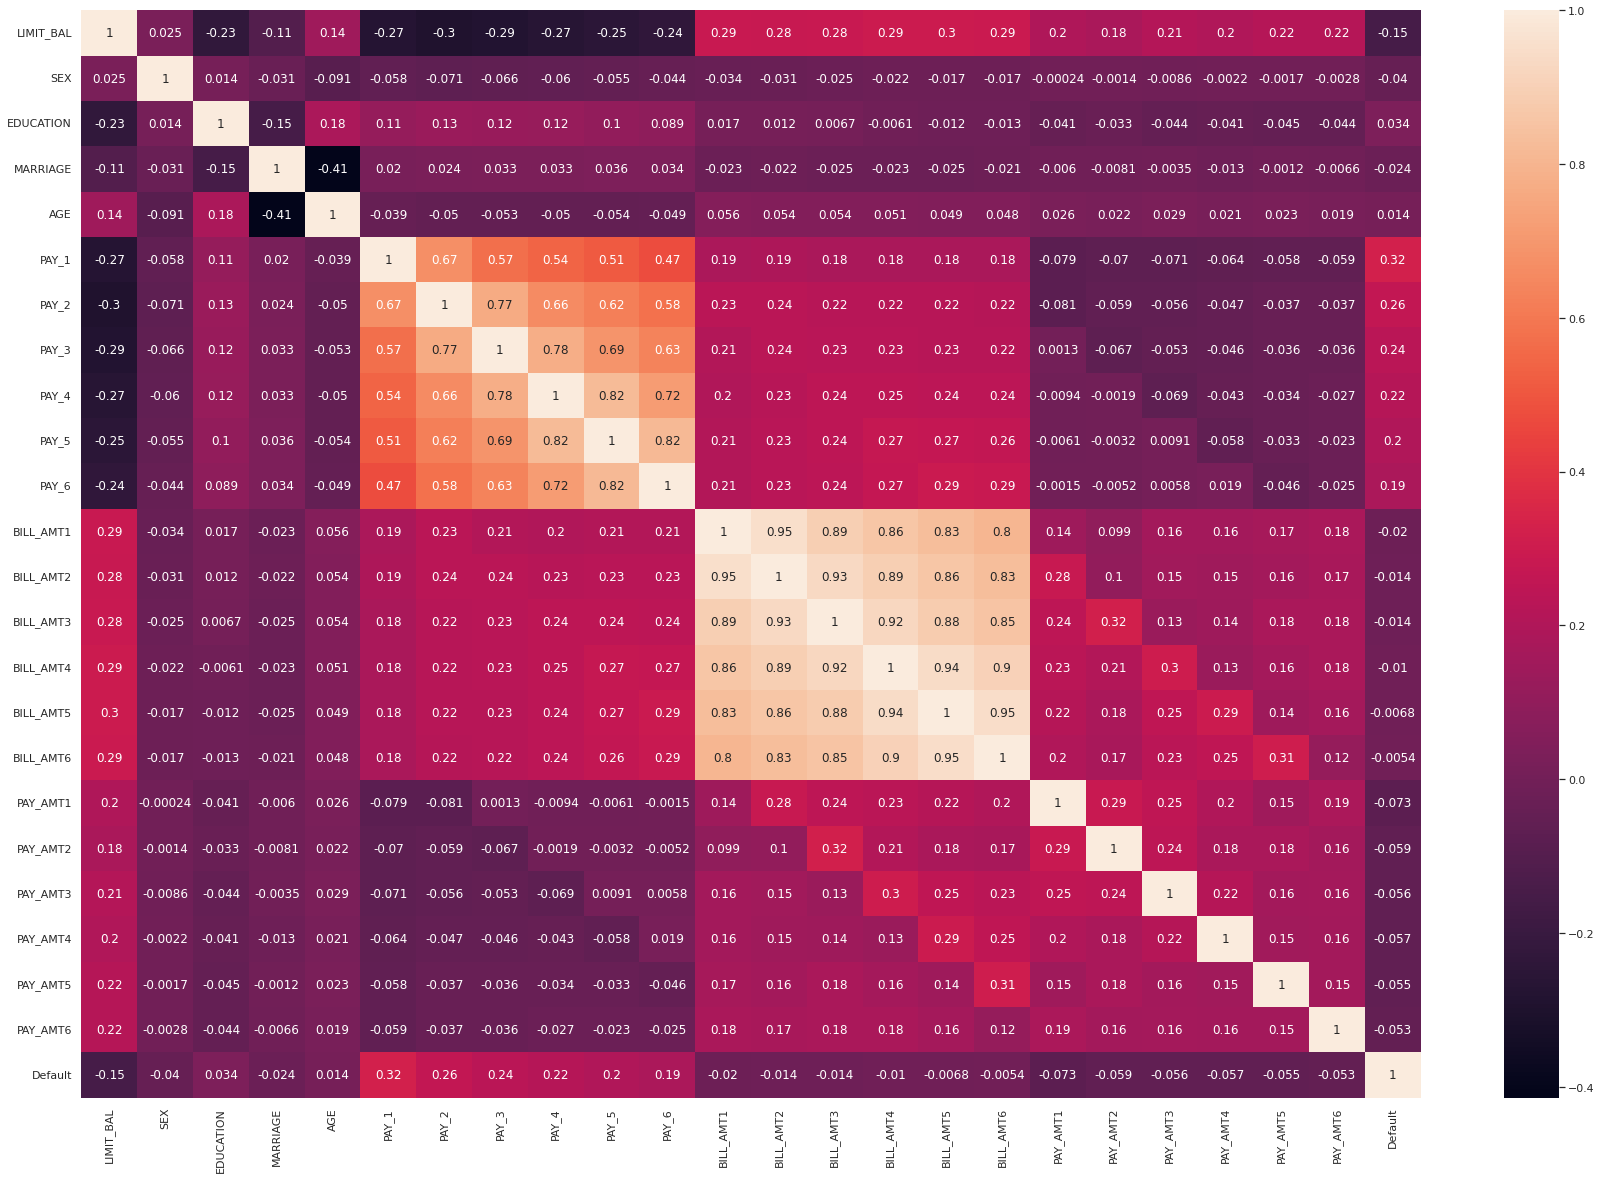

In [45]:
plt.subplots(figsize=(30,20))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [46]:
df=data.copy()
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


# III. Data preparation 

Organiser les données pour la modélisation

In [47]:
dataframe= df.copy()

In [48]:
bill_amt = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt  = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
bill_statement_sum = dataframe[bill_amt].sum(axis=1)
print(f"Number of observation with zero total bill amount {sum(bill_statement_sum == 0)}")
bill_statement_sum_index = bill_statement_sum.loc[bill_statement_sum > 0].index
dataframe = dataframe.loc[bill_statement_sum_index]
dataframe.shape

Number of observation with zero total bill amount 870


(28929, 24)

In [49]:
dataframe = dataframe.drop_duplicates(subset=[col for col in dataframe.columns if col != 'Default'])# drop duplicated rows
features_col = [col for col in dataframe.columns if col not in ['Default']]
features = dataframe[features_col]
target = dataframe['Default']
dataframe.shape

(28923, 24)

In [50]:
SEED=2020
X, X_test, y, y_test = train_test_split(features,
                                        target,
                                        test_size=.2,
                                        shuffle=True,
                                        random_state=SEED,
                                        stratify=target
                                        )

In [51]:
# proportion des modalités de 'default' entre train set et test set
unique_train, count_train = np.unique(y, return_counts=True)
print(f"y train value counts: \n {np.asanyarray((unique_train, count_train/y.shape[0])).T}")
print('\n')
unique_test, count_test = np.unique(y_test, return_counts=True)
print(f"y test value counts: \n {np.asanyarray((unique_test, count_test/y_test.shape[0])).T}")

y train value counts: 
 [[0.        0.7833002]
 [1.        0.2166998]]


y test value counts: 
 [[0.         0.78340536]
 [1.         0.21659464]]


In [52]:
scaler = MinMaxScaler() # StandardScaler MinMaxScaler
scaler.fit(X)
scaled_x = scaler.transform(X)
scaled_test = scaler.transform(X_test)
X.loc[:, features_col] = scaled_x
X_test.loc[:, features_col] = scaled_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
nnet_article_train = X.copy()
nnet_article_test  = X_test.copy()
scaler = StandardScaler()
scaler.fit(nnet_article_train) # Fit scaler
# Scale train data for logistic regression
scaled_train = scaler.transform(nnet_article_train) 
nnet_article_train.loc[:, features_col] = scaled_train
# Scale test data for logistic regression
scaled_test = scaler.transform(nnet_article_test)
nnet_article_test.loc[:, features_col] = scaled_test

# IV. Modeling 
##### Expliquer et justifier le choix, le paramétrage et le test de différents algorithmes 

## KNN sans Validation Croisée

In [54]:
# Classifier implementing the k-nearest neighbors vote.
knn = KNeighborsClassifier(n_neighbors=10, #number of neighbors to use
                           algorithm='kd_tree', # algo used to compute the nearest neighbors
                           n_jobs=-1, # number of parallel jobs to run for neighbors search : -1 means using all processors.
                           weights='uniform' # Weight function used in prediction : uniform means that all the points in each neighborhood are weighted equally.
                          )
knn.fit(X, y) # fit knn classifier 
train_pred_knn = knn.predict(X) # returns labels of the train data
train_proba_knn = knn.predict_proba(X) # returns probability estimates for the train data 
test_pred_knn = knn.predict(X_test) # returns labels of the test data
test_proba_knn = knn.predict_proba(X_test) # returns probability estimates for the test data 

## KNN avec Validation Croisée

In [55]:
%%time

NSPLITS = 5 # number of folds
SHUFFLE =True

oof_label_knn_cv = np.zeros((X.shape[0]))
oof_proba_knn_cv = np.zeros((X.shape[0], 2))
test_proba_knn_cv = np.zeros((X_test.shape[0], 2))

error_rate_valids_knn_cv = []
area_ratio_valids_knn_cv = []


skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)
# Stratified K-Folds provides train and test indices to split the data in train and test folds.
# the folds are made by preserving the percentage of samples for each class.

knn_cv = KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree', n_jobs=-1)

counter = 1

for trn_idx, vld_idx in skf.split(X, y):
    
    print(f"CV {counter}")
    # split the train data into NSPLITS=5 folds
    # x_valid and y_valid are considered as a holdout or test data set.
    # y_train and y_valid are considered as a training data set.
    x_train_knn_cv, x_valid_knn_cv  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
    y_train_knn_cv, y_valid_knn_cv  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    print(f"Shape of valid data: {x_valid_knn_cv.shape}")
    knn_cv.fit(x_train_knn_cv, y_train_knn_cv)
    
    oof_pred_label_knn_cv = knn_cv.predict(x_valid_knn_cv) # predicted labels on the out_of_fold data : the data were not used during the training of the model.
    oof_pred_proba_knn_cv = knn_cv.predict_proba(x_valid_knn_cv) # predicted labels on the out_of_fold data
    oof_label_knn_cv[vld_idx] = oof_pred_label_knn_cv
    oof_proba_knn_cv[vld_idx] = oof_pred_proba_knn_cv
    
    y_pred_test_knn_cv = knn_cv.predict_proba(X_test) # probability estimates for the test set 
    valid_pcg_knn_cv = decile_table(y_valid_knn_cv, oof_pred_proba_knn_cv[:, 1], labels=False)
    score_valid_knn_cv = 1 - accuracy_score(y_valid_knn_cv, oof_pred_label_knn_cv) # compute the error score for the holdout or test data set.
    area_ratio_valid_knn_cv = area_ratio(valid_pcg_knn_cv) # compute area_ratio score for the holdout or test data set.
    print(f"error rate fold {counter} score: {score_valid_knn_cv} | area ratio score: {area_ratio_valid_knn_cv}")
    error_rate_valids_knn_cv.append(score_valid_knn_cv) # appending the error scores of the holdouts to a list. 
    area_ratio_valids_knn_cv.append(area_ratio_valid_knn_cv) # appending the area_ratio scores of the holdouts to a list. 
    test_proba_knn_cv += y_pred_test_knn_cv / NSPLITS
    counter += 1
    print("\n")


CV 1
Shape of valid data: (4628, 23)
error rate fold 1 score: 0.19187554019014696 | area ratio score: 0.4469387492438573


CV 2
Shape of valid data: (4628, 23)
error rate fold 2 score: 0.1853932584269663 | area ratio score: 0.49133943395497875


CV 3
Shape of valid data: (4628, 23)
error rate fold 3 score: 0.1882022471910112 | area ratio score: 0.45874358083323685


CV 4
Shape of valid data: (4627, 23)
error rate fold 4 score: 0.18413658958288304 | area ratio score: 0.4640435589247158


CV 5
Shape of valid data: (4627, 23)
error rate fold 5 score: 0.18392046682515673 | area ratio score: 0.4998030812000462


CPU times: user 23.4 s, sys: 47.5 ms, total: 23.4 s
Wall time: 14.2 s


## Hyperparameter tuning avec optuna pour XGBoost

In [56]:
# defining an objective function to be optimized :
def objective(trial):

    param_grid = {
        "objective": "binary:logistic", # the loss function : logistic regression for binary classification
        "eval_metric":'error', # specify eval metric for xgboost
        'tree_method':'gpu_hist', 
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7]), # colsample_bytree is the subsample ratio of columns when constructing each tree
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7]), # Subsample ratio of the training instances
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5,6,7,9,11]), # max depth of the decision trees 
        'min_child_weight': trial.suggest_categorical('min_child_weight', [10, 30, 60, 100, 200])}

    skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)

    xgb_score = []
    counter = 1
    for trn_idx, vld_idx in skf.split(X, y):

        # train valid separation
        print(f"CV {counter}/{NSPLITS}")
        print('\n')
        # DMatrix a data structure used by XGBoost, which is optimized both for memory efficiency and training speed.  
        # We can construct a DMatrix from different data sources (numpy ,...)
        d_train = xgb.DMatrix(X.iloc[trn_idx].values, y.iloc[trn_idx].values)
        d_val = xgb.DMatrix(X.iloc[vld_idx].values, y.iloc[vld_idx].values)
        
        # Fit and train xgboost
        model = xgb.train(param_grid, d_train, evals=[(d_val, "val")], num_boost_round=10000, verbose_eval=50,
                          early_stopping_rounds=100)
    
        # Predictions and score on validation data
        pred_val = model.predict(d_val)
        predictions = [round(value) for value in pred_val]
        score = 1 - accuracy_score(y.iloc[vld_idx], predictions)
        print(f"Fold {counter} Xgboost {score}")
        xgb_score.append(score)
        counter += 1
  
    return np.mean(np.array(xgb_score))
# Create a study object and invoke the optimize method over 100 trials :
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)

In [57]:
# extreme gradient boosting trees :
# boosting : Ensemble learning technique that works by combining several weak learners into a model with strng accuracy
# in gradient boosting each predictor tries to improve on its predecessor by reducing the errors.
# at each iteration it fits a new predictor to the residual errors made by the previous predictor.Models are added sequentially until no further improvements can be made.

## XGBoost sans Validation Croisée

In [58]:
# optuna hyperparameter tuning output :
Best_trial= {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 100, "objective": "binary:logistic",
        "eval_metric":'error'}
# fiting XGBoost with **Best_trial :
xgboost = xgb.XGBClassifier(**Best_trial)
xgboost.fit(X, y, # fit xgboost classifier
            eval_set=[(X_test,y_test)], # evaluation on the Test set
              verbose=100,
            early_stopping_rounds=200)  
train_pred_xgb = xgboost.predict(X) # returns labels of the train data
train_proba_xgb = xgboost.predict_proba(X) # returns probability estimates for the train data 
test_pred_xgb = xgboost.predict(X_test) # returns labels of the test data
test_proba_xgb = xgboost.predict_proba(X_test) # returns probability estimates for the test data 

[0]	validation_0-error:0.21158


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[99]	validation_0-error:0.17736


## XGBoost avec Validation Croisée

In [59]:
%%time
# fiting XGBoost with **Best_trial and cross-validation :

NSPLITS = 5
SHUFFLE =True

oof_label_xgb_cv = np.zeros((X.shape[0]))
oof_proba_xgb_cv = np.zeros((X.shape[0], 2))
test_proba_xgb_cv = np.zeros((X_test.shape[0], 2))

error_rate_valids_xgb_cv = []
area_ratio_valids_xgb_cv = []


skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)


counter = 1

for trn_idx, vld_idx in skf.split(X, y):
    
    # split the train data into NSPLITS=5 folds
    # x_valid and y_valid are considered as a holdout or test data set.
    # y_train and y_valid are considered as a training data set.
    print(f"CV {counter}")
    x_train_xgb_cv, x_valid_xgb_cv  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
    y_train_xgb_cv, y_valid_xgb_cv  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    
    print(f"Shape pf valid data: {x_valid_xgb_cv.shape}")
    # Fit and train xgboost
    xgboost_cv = xgb.XGBClassifier(**Best_trial)
    xgboost_cv.fit(x_train_xgb_cv, y_train_xgb_cv, 
                eval_set=[(x_valid_xgb_cv,y_valid_xgb_cv)], # evaluation on the validation set
                verbose=100, early_stopping_rounds=200)
    
    oof_pred_label_xgb_cv = xgboost_cv.predict(x_valid_xgb_cv) # predicted labels on the out_of_fold data : the data were not used during the training of the model.
    oof_pred_proba_xgb_cv = xgboost_cv.predict_proba(x_valid_xgb_cv) # predicted labels on the out_of_fold data
    oof_label_xgb_cv[vld_idx] = oof_pred_label_xgb_cv
    oof_proba_xgb_cv[vld_idx] = oof_pred_proba_xgb_cv
    
    y_pred_test_xgb_cv = xgboost_cv.predict_proba(X_test) # probability estimates for the test set 
    valid_pcg_xgb_cv = decile_table(y_valid_xgb_cv , oof_pred_proba_xgb_cv[:, 1], labels=False)
    score_valid_xgb_cv = 1 - accuracy_score(y_valid_xgb_cv , oof_pred_label_xgb_cv) # compute the error score for the holdout or test data set.
    area_ratio_valid_xgb_cv = area_ratio(valid_pcg_xgb_cv) # compute area_ratio score for the holdout or test data set.
    print(f"error rate fold {counter} score: {score_valid_xgb_cv} | area ratio score: {area_ratio_valid_xgb_cv}")
    error_rate_valids_xgb_cv.append(score_valid_xgb_cv) # appending the error scores of the holdouts to a list. 
    area_ratio_valids_xgb_cv.append(area_ratio_valid_xgb_cv) # appending the area_ratio scores of the holdouts to a list. 
    test_proba_xgb_cv += y_pred_test_xgb_cv / NSPLITS
    counter += 1
    print("\n")

CV 1
Shape pf valid data: (4628, 23)
[0]	validation_0-error:0.21197


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[99]	validation_0-error:0.17437
error rate fold 1 score: 0.17372515125324117 | area ratio score: 0.5811627218554124


CV 2
Shape pf valid data: (4628, 23)
[0]	validation_0-error:0.20354
[99]	validation_0-error:0.17589
error rate fold 2 score: 0.1756698357821953 | area ratio score: 0.5390735807045315


CV 3
Shape pf valid data: (4628, 23)
[0]	validation_0-error:0.20311
[99]	validation_0-error:0.17675
error rate fold 3 score: 0.17610198789974074 | area ratio score: 0.53573497046218


CV 4
Shape pf valid data: (4627, 23)
[0]	validation_0-error:0.20856
[99]	validation_0-error:0.16966
error rate fold 4 score: 0.1690079965420359 | area ratio score: 0.5408326321396313


CV 5
Shape pf valid data: (4627, 23)
[0]	validation_0-error:0.20661
[99]	validation_0-error:0.16706
error rate fold 5 score: 0.16684676896477202 | area ratio score: 0.5785963422011148


CPU times: user 18.9 s, sys: 43.4 ms, total: 19 s
Wall time: 9.86 s


## Hyperparameter tuning avec optuna pour Logistic Regression

In [60]:
def objective_logistic(trial):
    solver = trial.suggest_categorical("solver", [ 'liblinear',  'lbfgs', 'sag', 'saga'])
    C = trial.suggest_float("C", 0.0, 1.0)
        # 'penalty' parameter isn't relevant for this solver,
        # so we always specify 'l2' as the dummy value.
    logistic = LogisticRegression(max_iter=200, solver=solver, C=C,random_state=SEED)

    skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)

    logistic_score = []
    counter = 1
    for trn_idx, vld_idx in skf.split(X, y):

        # train valid separation
        print(f"CV {counter}/{NSPLITS}")
        print('\n')
        x_train, x_valid  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
        y_train, y_valid  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
        
        # Fit and train logistic
        logistic.fit(x_train,y_train)
    
        # Predictions and score on validation data
        pred_val = logistic.predict(x_valid)
        
        score = 1 - accuracy_score(y_valid, pred_val)
        print(f"Fold {counter} logistic {score}")
        logistic_score.append(score)
        counter += 1
  
    return np.mean(np.array(logistic_score))
# Create a study object and invoke the optimize method over 100 trials :
#study = optuna.create_study(direction="minimize")
#study.optimize(objective_logistic, n_trials=100)
#print("Number of finished trials: ", len(study.trials))
#print("Best trial:")
#trial = study.best_trial
#print("  Value: ", trial.value)
#print("  Params: ")
#for key, value in trial.params.items():
 #      print("    {}: {}".format(key, value))

## Logistic Regression sans Validation Croisée

In [61]:
Params = {'solver': 'saga' ,'C': 0.9960292949722489} 
Logistic = LogisticRegression(**Params,penalty='l2',max_iter=200)
Logistic.fit(X, y)  
train_pred_Logistic = Logistic.predict(X)
train_proba_Logistic = Logistic.predict_proba(X)
test_pred_Logistic = Logistic.predict(X_test)
test_proba_Logistic = Logistic.predict_proba(X_test)

## Logistic Regression avec Validation Croisée

In [62]:
%%time

NSPLITS = 5
SHUFFLE =True

oof_label_Logistic_cv = np.zeros((X.shape[0]))
oof_proba_Logistic_cv = np.zeros((X.shape[0], 2))
test_proba_Logistic_cv = np.zeros((X_test.shape[0], 2))

error_rate_valids_Logistic_cv = []
area_ratio_valids_Logistic_cv = []


skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)


counter = 1

for trn_idx, vld_idx in skf.split(X, y):
    
    print(f"CV {counter}")
    # split the train data into NSPLITS=5 folds
    # x_valid and y_valid are considered as a holdout or test data set.
    # y_train and y_valid are considered as a training data set.
    x_train_Logistic_cv, x_valid_Logistic_cv  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
    y_train_Logistic_cv, y_valid_Logistic_cv  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    
    print(f"Shape pf valid data: {x_valid_Logistic_cv.shape}")
    # Fit and train LogisticRegression
    Logistic_cv = LogisticRegression(**Params,penalty='l2',max_iter=200)

    Logistic_cv.fit(x_train_Logistic_cv, y_train_Logistic_cv)
    
    oof_pred_label_Logistic_cv = Logistic_cv.predict(x_valid_Logistic_cv) # predicted labels on the out_of_fold data : the data were not used during the training of the model.
    oof_pred_proba_Logistic_cv = Logistic_cv.predict_proba(x_valid_Logistic_cv) # predicted labels on the out_of_fold data
    oof_label_Logistic_cv[vld_idx] = oof_pred_label_Logistic_cv
    oof_proba_Logistic_cv[vld_idx] = oof_pred_proba_Logistic_cv
    
    y_pred_test_Logistic_cv = Logistic_cv.predict_proba(X_test) # probability estimates for the test set 
    valid_pcg_Logistic_cv = decile_table(y_valid_Logistic_cv , oof_pred_proba_Logistic_cv[:, 1], labels=False)
    score_valid_Logistic_cv = 1 - accuracy_score(y_valid_Logistic_cv , oof_pred_label_Logistic_cv) # compute the error score for the holdout or test data set.
    
    area_ratio_valid_Logistic_cv = area_ratio(valid_pcg_Logistic_cv) # compute area_ratio score for the holdout or test data set.
    print(f"error rate fold {counter} score: {score_valid_Logistic_cv} | area ratio score: {area_ratio_valid_Logistic_cv}")
    error_rate_valids_Logistic_cv.append(score_valid_Logistic_cv)
    area_ratio_valids_Logistic_cv.append(area_ratio_valid_Logistic_cv)
    test_proba_Logistic_cv+= y_pred_test_Logistic_cv/ NSPLITS
    counter += 1
    print("\n")


CV 1
Shape pf valid data: (4628, 23)
error rate fold 1 score: 0.18647363872082978 | area ratio score: 0.46208219107558834


CV 2
Shape pf valid data: (4628, 23)
error rate fold 2 score: 0.18560933448573902 | area ratio score: 0.4556649548888628


CV 3
Shape pf valid data: (4628, 23)
error rate fold 3 score: 0.18604148660328435 | area ratio score: 0.43076824073001524


CV 4
Shape pf valid data: (4627, 23)
error rate fold 4 score: 0.18651393991787335 | area ratio score: 0.4563420075497333


CV 5
Shape pf valid data: (4627, 23)
error rate fold 5 score: 0.18283985303652472 | area ratio score: 0.5075073683668613


CPU times: user 1.86 s, sys: 343 ms, total: 2.2 s
Wall time: 1.59 s


## Hyperparameter tuning avec optuna pour Random Forest

In [63]:
def objective_random_forest(trial):

    

    params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),# number of trees in the forest
            'max_depth': trial.suggest_int('max_depth', 4, 50),#number of levels in each decesion tree
            'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),#min number of data points placed in a node before the node split
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60)#min number of data points allowed in a leaf node
        }

    
    rfc = RandomForestClassifier(**params,n_jobs=2,random_state=SEED)

    skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)

    rfc_score = []
    counter = 1
    for trn_idx, vld_idx in skf.split(X, y):

        # train valid separation
        print(f"CV {counter}/{NSPLITS}")
        print('\n')
        x_train, x_valid  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
        y_train, y_valid  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
        
        # Fit and train RandomForestClassifier
        rfc.fit(x_train,y_train)
    
        # Predictions and score on validation data
        pred_val = rfc.predict(x_valid)
        
        score = 1 - accuracy_score(y_valid, pred_val)
        print(f"Fold {counter} RFC {score}")
        rfc_score.append(score)
        counter += 1
  
    return np.mean(np.array(rfc_score))
#study = optuna.create_study(direction="minimize")
#study.optimize(objective_random_forest, n_trials=100)
#
#print("Number of finished trials: ", len(study.trials))
#print("Best trial:")
#trial = study.best_trial
#print("  Value: ", trial.value)
#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

## Random Forest sans Validation Croisée

In [64]:
RF = RandomForestClassifier(max_depth=7,n_estimators=400,criterion='gini',verbose=0)
RF.fit(X, y)  
train_pred_RF = RF.predict(X)
train_proba_RF = RF.predict_proba(X)
test_pred_RF = RF.predict(X_test)
test_proba_RF = RF.predict_proba(X_test)

## Random Forest avec Validation Croisée

In [65]:
%%time

NSPLITS = 5
SHUFFLE =True

oof_label_RF_CV = np.zeros((X.shape[0]))
oof_proba_RF_CV = np.zeros((X.shape[0], 2))
test_proba_RF_CV = np.zeros((X_test.shape[0], 2))

error_rate_valids_RF_CV = []
area_ratio_valids_RF_CV = []


skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)


counter = 1

for trn_idx, vld_idx in skf.split(X, y):
    
    print(f"CV {counter}")
    x_train_RF_CV, x_valid_RF_CV  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
    y_train_RF_CV, y_valid_RF_CV  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    
    print(f"Shape pf valid data: {x_valid_RF_CV.shape}")
    # Fit and train RandomForestClassifier
    RF_CV = RandomForestClassifier(max_depth=7, # The maximum depth of the tree
                                   n_estimators=400, # the number of trees the algorithm builds before taking the maximum voting or the averages of predictions
                                   criterion='gini', # gini impurity
                                   verbose=0)

    RF_CV.fit(x_train_RF_CV, y_train_RF_CV)
    
    oof_pred_label_RF_CV = RF_CV.predict(x_valid_RF_CV) #the predicted label for the test folds
    
    oof_pred_proba_RF_CV = RF_CV.predict_proba(x_valid_RF_CV) 
    
    oof_label_RF_CV[vld_idx] = oof_pred_label_RF_CV
    oof_proba_RF_CV[vld_idx] = oof_pred_proba_RF_CV
    
    y_pred_test_RF_CV = RF_CV.predict_proba(X_test)
    
    valid_pcg_RF_CV = decile_table(y_valid_RF_CV , oof_pred_proba_RF_CV[:, 1], labels=False)
    
    score_valid_RF_CV = 1 - accuracy_score(y_valid_RF_CV , oof_pred_label_RF_CV) # score of each fold
    
    area_ratio_valid_RF_CV = area_ratio(valid_pcg_RF_CV)
    
    print(f"error rate fold {counter} score: {score_valid_RF_CV} | area ratio score: {area_ratio_valid_RF_CV}")
    
    error_rate_valids_RF_CV.append(score_valid_RF_CV) # append error rate folds
    area_ratio_valids_RF_CV.append(area_ratio_valid_RF_CV)
    test_proba_RF_CV += y_pred_test_RF_CV / NSPLITS # predictproba for all the folds ***
    counter += 1
    print("\n")

CV 1
Shape pf valid data: (4628, 23)
error rate fold 1 score: 0.17502160760587726 | area ratio score: 0.5773144394249453


CV 2
Shape pf valid data: (4628, 23)
error rate fold 2 score: 0.17242869490060497 | area ratio score: 0.5403554834807008


CV 3
Shape pf valid data: (4628, 23)
error rate fold 3 score: 0.17783059636992227 | area ratio score: 0.5444611761071856


CV 4
Shape pf valid data: (4627, 23)
error rate fold 4 score: 0.17095310136157338 | area ratio score: 0.5431407816830192


CV 5
Shape pf valid data: (4627, 23)
error rate fold 5 score: 0.17030473308839422 | area ratio score: 0.5850110042858798


CPU times: user 48.4 s, sys: 56.2 ms, total: 48.5 s
Wall time: 48.6 s


## Linear Discriminant Analysis sans Validation Croisée

In [66]:
LDA = LinearDiscriminantAnalysis(solver='svd')
LDA.fit(X, y)  
train_pred_LDA = LDA.predict(X)
train_proba_LDA = LDA.predict_proba(X)
test_pred_LDA = LDA.predict(X_test)
test_proba_LDA = LDA.predict_proba(X_test)

## Linear Discriminant Analysis avec Validation Croisée

In [67]:
%%time

NSPLITS = 5
SHUFFLE =True

oof_label_LDA_CV = np.zeros((X.shape[0]))
oof_proba_LDA_CV = np.zeros((X.shape[0], 2))
test_proba_LDA_CV = np.zeros((X_test.shape[0], 2))

error_rate_valids_LDA_CV = []
area_ratio_valids_LDA_CV = []


skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)


counter = 1

for trn_idx, vld_idx in skf.split(X, y):
    
    print(f"CV {counter}")
    x_train_LDA_CV, x_valid_LDA_CV  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
    y_train_LDA_CV, y_valid_LDA_CV  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    
    print(f"Shape pf valid data: {x_valid_LDA_CV.shape}")
    # Fit and train LinearDiscriminantAnalysis
    LDA_CV = LinearDiscriminantAnalysis(solver='svd')

    LDA_CV.fit(x_train_LDA_CV, y_train_LDA_CV)
    
    oof_pred_label_LDA_CV = LDA_CV.predict(x_valid_LDA_CV)
    oof_pred_proba_LDA_CV = LDA_CV.predict_proba(x_valid_LDA_CV)
    oof_label_LDA_CV[vld_idx] = oof_pred_label_LDA_CV
    oof_proba_LDA_CV[vld_idx] = oof_pred_proba_LDA_CV
    
    y_pred_test_LDA_CV = LDA_CV.predict_proba(X_test)
    valid_pcg_LDA_CV = decile_table(y_valid_LDA_CV , oof_pred_proba_LDA_CV[:, 1], labels=False)
    score_valid_LDA_CV = 1 - accuracy_score(y_valid_LDA_CV , oof_pred_label_LDA_CV)
    
    area_ratio_valid_LDA_CV = area_ratio(valid_pcg_LDA_CV)
    print(f"error rate fold {counter} score: {score_valid_LDA_CV} | area ratio score: {area_ratio_valid_LDA_CV}")
    error_rate_valids_LDA_CV.append(score_valid_LDA_CV)
    area_ratio_valids_LDA_CV.append(area_ratio_valid_LDA_CV)
    test_proba_LDA_CV += y_pred_test_LDA_CV / NSPLITS
    counter += 1
    print("\n")

CV 1
Shape pf valid data: (4628, 23)
error rate fold 1 score: 0.18344857389801206 | area ratio score: 0.4592584012252727


CV 2
Shape pf valid data: (4628, 23)
error rate fold 2 score: 0.18344857389801206 | area ratio score: 0.44693617514189715


CV 3
Shape pf valid data: (4628, 23)
error rate fold 3 score: 0.18560933448573902 | area ratio score: 0.42820443517767764


CV 4
Shape pf valid data: (4627, 23)
error rate fold 4 score: 0.18348822130970388 | area ratio score: 0.44247767116202585


CV 5
Shape pf valid data: (4627, 23)
error rate fold 5 score: 0.18003025718608168 | area ratio score: 0.5023720349563046


CPU times: user 1.04 s, sys: 359 ms, total: 1.4 s
Wall time: 749 ms


## Neural Network sans Validation Croisée

In [68]:
# Instantiation of the Logisti algorithm
nnet_params = {
    'hidden_layer_sizes':(250, 150,), # Hidden layer size
    'activation':'tanh',
    'alpha':1e-4, # Weight decay (L2 regularization)
    'batch_size':2**7, # Batch size
    'solver':'adam', # Optimizer
    'learning_rate':'adaptive',
    'max_iter':100, # Number of iteration
    'verbose':True,
    'early_stopping':True,
    'random_state':2022
}
nnet = MLPClassifier(**nnet_params)
# Train the model
nnet.fit(nnet_article_train, y)
# Predict proba & labels on the train data
train_pred_nnet = nnet.predict(nnet_article_train)
train_proba_nnet = nnet.predict_proba(nnet_article_train)

Iteration 1, loss = 0.45451958
Validation score: 0.817200
Iteration 2, loss = 0.43527412
Validation score: 0.819793
Iteration 3, loss = 0.43058054
Validation score: 0.829300
Iteration 4, loss = 0.42479177
Validation score: 0.827571
Iteration 5, loss = 0.42291708
Validation score: 0.823250
Iteration 6, loss = 0.42278656
Validation score: 0.830164
Iteration 7, loss = 0.42034686
Validation score: 0.822818
Iteration 8, loss = 0.41926273
Validation score: 0.827139
Iteration 9, loss = 0.41678101
Validation score: 0.827571
Iteration 10, loss = 0.41576652
Validation score: 0.828436
Iteration 11, loss = 0.41422302
Validation score: 0.826707
Iteration 12, loss = 0.41338705
Validation score: 0.824546
Iteration 13, loss = 0.41215619
Validation score: 0.828003
Iteration 14, loss = 0.41162880
Validation score: 0.826275
Iteration 15, loss = 0.41042820
Validation score: 0.830596
Iteration 16, loss = 0.40839469
Validation score: 0.829300
Iteration 17, loss = 0.40790835
Validation score: 0.829300
Iterat

## Neural Network avec Validation Croisée

In [69]:
%%time

# Vector placeholders for score computation over a fold
oof_label_nnet_CV = np.zeros((nnet_article_train.shape[0]))
oof_proba_nnet_CV = np.zeros((nnet_article_train.shape[0], 2))
test_proba_nnet_CV = np.zeros((nnet_article_test.shape[0], 2))

# Placeholders for mean score computation over all folds
error_rate_valids_nnet_CV = []
area_ratio_valids_nnet_CV = []

# Instantiation of the Stratified kfold generator
skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)

# Instantiation of the KNN algorithm
nnet_params = {
    'hidden_layer_sizes':(250, 150,), # Hidden layer size
    'activation':'tanh',
    'alpha':1e-4, # Weight decay (L2 regularization)
    'batch_size':2**7, # Batch size
    'solver':'adam', # Optimizer
    'learning_rate':'adaptive',
    'max_iter':100, # Number of iteration
    'verbose':True,
    'early_stopping':True,
    'random_state':2022
}                        

counter = 1

# Loop over the folds
for trn_idx, vld_idx in skf.split(nnet_article_train, y):
    
    print(f"CV {counter}")
    # Separate train and validation data
    x_train_nnet_CV, x_valid_nnet_CV = nnet_article_train.iloc[trn_idx].values, nnet_article_train.iloc[vld_idx].values
    y_train_nnet_CV, y_valid_nnet_CV = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    # train the model
    nnet.fit(x_train_nnet_CV, y_train_nnet_CV)
    
    # Predict label and probability on validation data
    oof_pred_label_nnet_CV = nnet.predict(x_valid_nnet_CV)
    oof_pred_proba_nnet_CV = nnet.predict_proba(x_valid_nnet_CV)
    oof_label_nnet_CV[vld_idx] = oof_pred_label_nnet_CV
    oof_proba_nnet_CV[vld_idx] = oof_pred_proba_nnet_CV
    
    # Area ratio computation
    valid_pcg_nnet_CV = decile_table(y_valid_nnet_CV, oof_pred_proba_nnet_CV[:, 1], labels=False)
    area_ratio_valid_nnet_CV = area_ratio(valid_pcg_nnet_CV)
    # Error rate computation
    score_valid_nnet_CV = 1 - accuracy_score(y_valid_nnet_CV, oof_pred_label_nnet_CV)
    print(f"error rate fold {counter} score: {score_valid_nnet_CV} | area ratio score: {area_ratio_valid_nnet_CV}")
    error_rate_valids_nnet_CV.append(score_valid_nnet_CV)
    area_ratio_valids_nnet_CV.append(area_ratio_valid_nnet_CV)
    
    # Prediction on the test set
    y_pred_test_nnet_CV = nnet.predict_proba(nnet_article_test)
    test_proba_nnet_CV += y_pred_test_nnet_CV / NSPLITS
    counter += 1
    print("\n")


CV 1
Iteration 1, loss = 0.45870400
Validation score: 0.817396
Iteration 2, loss = 0.43582171
Validation score: 0.817396
Iteration 3, loss = 0.42920923
Validation score: 0.823879
Iteration 4, loss = 0.42640157
Validation score: 0.819557
Iteration 5, loss = 0.42432596
Validation score: 0.819017
Iteration 6, loss = 0.42276330
Validation score: 0.815235
Iteration 7, loss = 0.42059714
Validation score: 0.822258
Iteration 8, loss = 0.41831849
Validation score: 0.820637
Iteration 9, loss = 0.41652396
Validation score: 0.819017
Iteration 10, loss = 0.41517885
Validation score: 0.822798
Iteration 11, loss = 0.41325713
Validation score: 0.819557
Iteration 12, loss = 0.41256253
Validation score: 0.817396
Iteration 13, loss = 0.41137800
Validation score: 0.818476
Iteration 14, loss = 0.40905823
Validation score: 0.816856
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
error rate fold 1 score: 0.17480553154710454 | area ratio score: 0.540607745472798




## DecisionTree sans Validation Croisée

In [70]:
DT = DecisionTreeClassifier(max_depth=7, # The maximum depth of the tree to prevent overfitting
                                   criterion='gini', # gini impurity
                                   random_state=SEED
                                   )
# Train the model
DT.fit(X, y)
# Predict proba & labels on the train data
train_pred_DT = DT.predict(X)
train_proba_DT = DT.predict_proba(X)
test_pred_DT = knn.predict(X_test)
test_proba_DT = knn.predict_proba(X_test)

## DecisionTree avec Validation Croisée

In [71]:
%%time

NSPLITS = 5
SHUFFLE =True

oof_label_DT_cv = np.zeros((X.shape[0]))
oof_proba_DT_cv = np.zeros((X.shape[0], 2))
test_proba_DT_cv = np.zeros((X_test.shape[0], 2))

error_rate_valids_DT_cv = []
area_ratio_valids_DT_cv = []

skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)

counter = 1

for trn_idx, vld_idx in skf.split(X, y):
    
    print(f"CV {counter}")
    x_train_DT_cv, x_valid_DT_cv  = X.iloc[trn_idx].values, X.iloc[vld_idx].values
    y_train_DT_cv, y_valid_DT_cv  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    
    print(f"Shape pf valid data: {x_valid_DT_cv.shape}")
    # Fit and train LogisticRegression
    DT_cv = DecisionTreeClassifier(max_depth=7, # The maximum depth of the tree to prevent overfitting
                                   criterion='gini', # gini impurity
                                   random_state=SEED
                                   )

    DT_cv.fit(x_train_DT_cv, y_train_DT_cv)
    
    oof_pred_label_DT_cv = DT_cv.predict(x_valid_DT_cv) #the predicted label for the test folds
    oof_pred_proba_DT_cv = DT_cv.predict_proba(x_valid_DT_cv)
    oof_label_DT_cv[vld_idx] = oof_pred_label_DT_cv
    oof_proba_DT_cv[vld_idx] = oof_pred_proba_DT_cv
    
    y_pred_test_DT_cv = DT_cv.predict_proba(X_test)
    valid_pcg_DT_cv = decile_table(y_valid_DT_cv , oof_pred_proba_DT_cv[:, 1], labels=False)
    score_valid_DT_cv = 1 - accuracy_score(y_valid_DT_cv , oof_pred_label_DT_cv) # score of each fold
    
    area_ratio_valid_DT_cv = area_ratio(valid_pcg_DT_cv)
    print(f"error rate fold {counter} score: {score_valid_DT_cv} | area ratio score: {area_ratio_valid_DT_cv}")
    error_rate_valids_DT_cv.append(score_valid_DT_cv) # append error rate folds
    area_ratio_valids_DT_cv.append(area_ratio_valid_DT_cv)
    test_proba_DT_cv+= y_pred_test_DT_cv/ NSPLITS # predictproba for all the folds ***
    counter += 1
    print("\n")


CV 1
Shape pf valid data: (4628, 23)
error rate fold 1 score: 0.18431287813310282 | area ratio score: 0.5121253072834214


CV 2
Shape pf valid data: (4628, 23)
error rate fold 2 score: 0.17458945548833193 | area ratio score: 0.4982689164317797


CV 3
Shape pf valid data: (4628, 23)
error rate fold 3 score: 0.1810717372515125 | area ratio score: 0.5054532350026384


CV 4
Shape pf valid data: (4627, 23)
error rate fold 4 score: 0.17354657445429 | area ratio score: 0.5069360279756989


CV 5
Shape pf valid data: (4627, 23)
error rate fold 5 score: 0.17484331100064832 | area ratio score: 0.5321440982277308


CPU times: user 1.01 s, sys: 11.6 ms, total: 1.02 s
Wall time: 1.02 s


## Naive Bayes sans Validation Croisée

In [72]:
NB_train = X.copy()
NB_test  = X_test.copy()
scaler = StandardScaler()
scaler.fit(X) # Fit scaler
# Scale train data for logistic regression
scaled_train = scaler.transform(NB_train) 
NB_train.loc[:, features_col] = scaled_train
# Scale test data for logistic regression
scaled_test = scaler.transform(NB_test)
NB_test.loc[:, features_col] = scaled_test

In [73]:
NB = GaussianNB()
NB.fit(NB_train,y)
train_pred_NB = NB.predict(NB_train)
train_proba_NB = NB.predict_proba(NB_train)
train_pcg_NB = decile_table(y, train_proba_NB[:, 1], labels=False)
test_pred_NB = NB.predict(NB_test)
test_proba_NB = NB.predict_proba(NB_test)

## Naive Bayes avec Validation Croisée

In [74]:
%%time

NSPLITS = 5
SHUFFLE =True

oof_label_NB_cv = np.zeros((X.shape[0]))
oof_proba_NB_cv = np.zeros((X.shape[0], 2))
test_proba_NB_cv = np.zeros((X_test.shape[0], 2))

error_rate_valids_NB_cv = []
area_ratio_valids_NB_cv = []

skf = StratifiedKFold(n_splits=NSPLITS, shuffle=SHUFFLE, random_state=SEED)

counter = 1

for trn_idx, vld_idx in skf.split(NB_train, y):
    
    print(f"CV {counter}")
    x_train_NB_cv, x_valid_NB_cv  = NB_train.iloc[trn_idx].values,NB_train.iloc[vld_idx].values
    y_train_NB_cv, y_valid_NB_cv  = y.iloc[trn_idx].values, y.iloc[vld_idx].values
    
    print(f"Shape pf valid data: {x_valid_NB_cv.shape}")
    # Fit and train LogisticRegression
    NB_cv = GaussianNB()

    NB_cv.fit(x_train_NB_cv, y_train_NB_cv)
    
    oof_pred_label_NB_cv = NB_cv.predict(x_valid_NB_cv)
    oof_pred_proba_NB_cv = NB_cv.predict_proba(x_valid_NB_cv)
    oof_label_NB_cv[vld_idx] = oof_pred_label_NB_cv
    oof_proba_NB_cv[vld_idx] = oof_pred_proba_NB_cv
    
    y_pred_test_NB_cv = NB_cv.predict_proba(NB_test)
    valid_pcg_NB_cv = decile_table(y_valid_NB_cv , oof_pred_proba_NB_cv[:, 1], labels=False)
    score_valid_NB_cv = 1 - accuracy_score(y_valid_NB_cv, oof_pred_label_NB_cv)
    
    area_ratio_valid_NB_cv = area_ratio(valid_pcg_NB_cv)
    print(f"error rate fold {counter} score: {score_valid_NB_cv} | area ratio score: {area_ratio_valid_NB_cv}")
    error_rate_valids_NB_cv.append(score_valid_NB_cv)
    area_ratio_valids_NB_cv.append(area_ratio_valid_NB_cv)
    test_proba_NB_cv+= y_pred_test_NB_cv/ NSPLITS
    counter += 1
    print("\n")


CV 1
Shape pf valid data: (4628, 23)
error rate fold 1 score: 0.22817631806395855 | area ratio score: 0.5026268710503621


CV 2
Shape pf valid data: (4628, 23)
error rate fold 2 score: 0.22860847018150388 | area ratio score: 0.4787649458795064


CV 3
Shape pf valid data: (4628, 23)
error rate fold 3 score: 0.3712186689714779 | area ratio score: 0.4525863289444897


CV 4
Shape pf valid data: (4627, 23)
error rate fold 4 score: 0.2470283120812622 | area ratio score: 0.4535166472390979


CV 5
Shape pf valid data: (4627, 23)
error rate fold 5 score: 0.2403285065917441 | area ratio score: 0.5023720349563049


CPU times: user 200 ms, sys: 165 µs, total: 200 ms
Wall time: 198 ms


# V. Evaluation
###### Vérifier le(s) modèle(s) ou les connaissances obtenues afin de s’assurer qu’ils répondent aux objectifs formulés au début du processus.


## KNN

#### Sans CV

KNN error rate on train set (training): 0.16799204771371767 | area ratio on train set (training): 0.6987177341917815

KNN error rate on test (valid) set: 0.18755401901469315 | area ratio on test (valid) set: 0.4378131860495638 



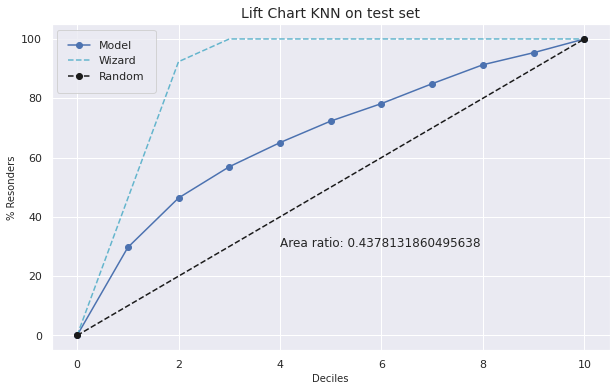

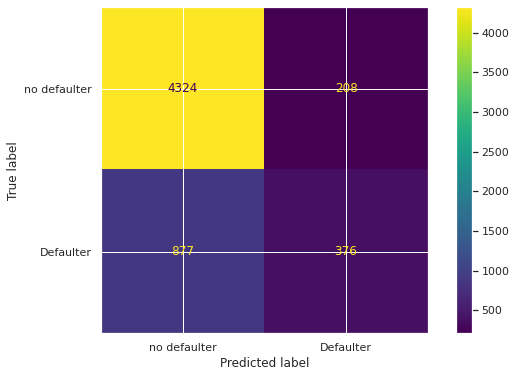

In [75]:
train_pcg_knn = decile_table(y, train_proba_knn[:, 1], labels=False)# calling the decile_table function with 'y' : labels for train 
                                                                    # and 'train_proba[:, 1]' : column  that contains the probability estimated for default==1
test_pcg_knn = decile_table(y_test, test_proba_knn[:, 1], labels=False) # calling the decile_table function with y_test and probability estimates of default==1
error_rate_train_knn = 1 - accuracy_score(y, train_pred_knn)
area_ratio_train_knn = area_ratio(train_pcg_knn) # calling area_ratio function
error_rate_test_knn = 1 - accuracy_score(y_test, test_pred_knn)
area_ratio_test_knn = area_ratio(test_pcg_knn)
y_pred_label_knn = test_proba_knn.argmax(1)
print(f"KNN error rate on train set (training): {error_rate_train_knn} | area ratio on train set (training): {area_ratio_train_knn}\n")
print(f"KNN error rate on test (valid) set: {error_rate_test_knn} | area ratio on test (valid) set: {area_ratio_test_knn} \n")
plot_lift_chart(test_pcg_knn, area_ratio_test_knn, title='Lift Chart KNN on test set')
cm = confusion_matrix(y_test, y_pred_label_knn, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

#### Avec CV

Error rate CV score: 0.18670562044323286 | Area ratio score: 0.4721736808313669

Error rate test (validation) score: 0.1828867761452031 | Area ratio score: 0.4544520997459764




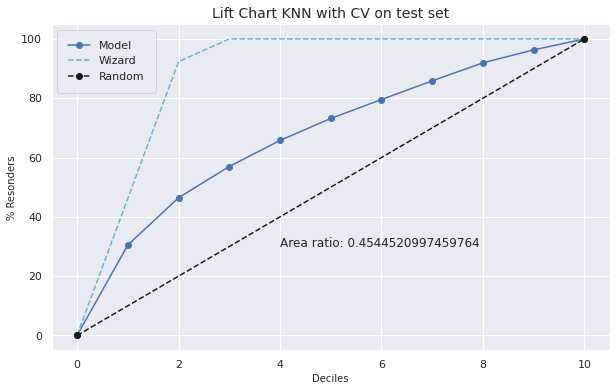

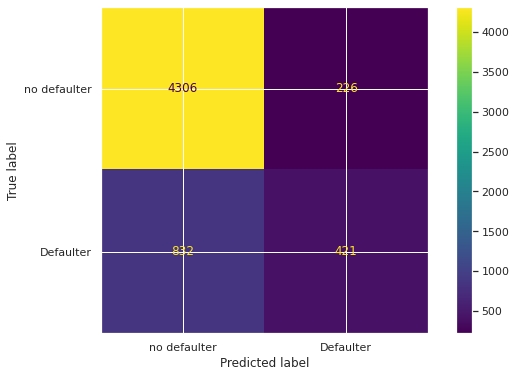

In [76]:
y_pred_label_knn_cv = test_proba_knn_cv.argmax(1) #Returns the indices of the maximum values along an axis.
test_pcg_knn_cv = decile_table(y_test, test_proba_knn_cv[:,1], labels=False)
test_area_ratio_knn_cv = area_ratio(test_pcg_knn_cv)
print(f"Error rate CV score: {np.mean(np.array(error_rate_valids_knn_cv))} | Area ratio score: {np.mean(np.array(area_ratio_valids_knn_cv))}\n")
print(f"Error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_knn_cv)} | Area ratio score: {test_area_ratio_knn_cv}")
plot_lift_chart(test_pcg_knn_cv, test_area_ratio_knn_cv, title='Lift Chart KNN with CV on test set')
cm = confusion_matrix(y_test, y_pred_label_knn_cv, labels=knn_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()
print("\n")

## XGBoost

#### Sans CV

XGB error rate on train set (training): 0.17352407295358285 | area ratio on train set (training): 0.5739072680607437

XGB error rate on test (valid) set: 0.1771823681936041 | area ratio on test (valid) set: 0.5503761449708786 



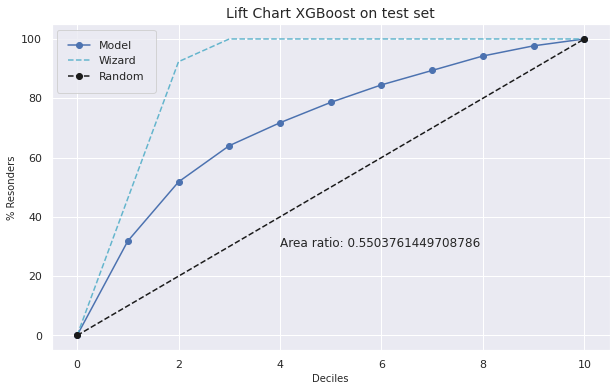

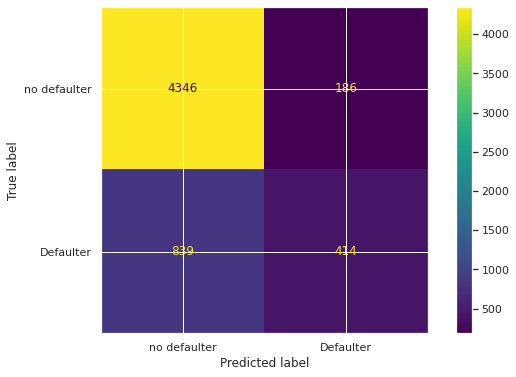

In [77]:
train_pcg_xgb = decile_table(y, train_proba_xgb[:, 1], labels=False)
test_pcg_xgb = decile_table(y_test, test_proba_xgb[:, 1], labels=False)
error_rate_train_xgb = 1 - accuracy_score(y, train_pred_xgb)
area_ratio_train_xgb = area_ratio(train_pcg_xgb)
error_rate_test_xgb = 1 - accuracy_score(y_test, test_pred_xgb)
area_ratio_test_xgb = area_ratio(test_pcg_xgb)
y_pred_label_xgb = test_proba_xgb.argmax(1)
print(f"XGB error rate on train set (training): {error_rate_train_xgb} | area ratio on train set (training): {area_ratio_train_xgb}\n")
print(f"XGB error rate on test (valid) set: {error_rate_test_xgb} | area ratio on test (valid) set: {area_ratio_test_xgb} \n")
plot_lift_chart(test_pcg_xgb, area_ratio_test_xgb, title='Lift Chart XGBoost on test set')
cm = confusion_matrix(y_test, y_pred_label_xgb, labels=xgboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

#### Avec CV

Error rate CV score: 0.17227034808839703 | Area ratio score: 0.555080049472574

Error rate test (validation) score: 0.1759723422644771 | Area ratio score: 0.5497610327708107




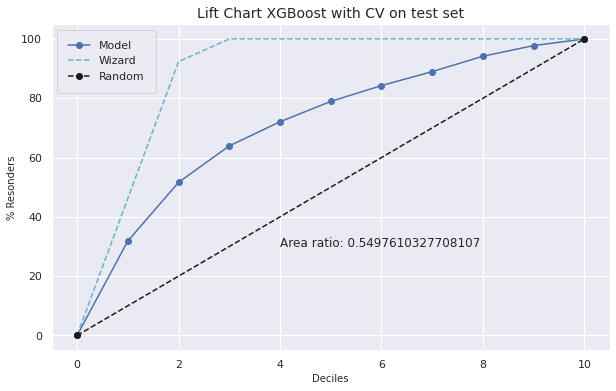

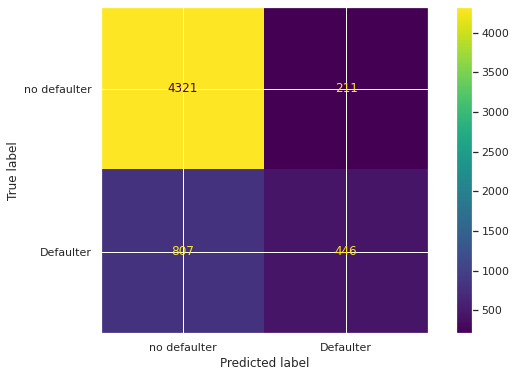

In [78]:
y_pred_label_xgb_cv = test_proba_xgb_cv.argmax(1) #Returns the indices of the maximum values along an axis.
test_pcg_xgb_cv = decile_table(y_test, test_proba_xgb_cv[:, 1], labels=False)
test_area_ratio_xgb_cv = area_ratio(test_pcg_xgb_cv)
print(f"Error rate CV score: {np.mean(np.array(error_rate_valids_xgb_cv))} | Area ratio score: {np.mean(np.array(area_ratio_valids_xgb_cv))}\n")
print(f"Error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_xgb_cv)} | Area ratio score: {test_area_ratio_xgb_cv}")
plot_lift_chart(test_pcg_xgb_cv, test_area_ratio_xgb_cv, title='Lift Chart XGBoost with CV on test set')
print("\n")
cm = confusion_matrix(y_test, y_pred_label_xgb_cv, labels=xgboost_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

## Logistic Regression

#### Sans CV

Logistic Regression error rate on train set (training): 0.18558215921860144 | area ratio on train set (training): 0.465881329272782

Logistic Regression error rate on test (valid) set: 0.18254105445116686 | area ratio on test (valid) set: 0.45117064344854013 



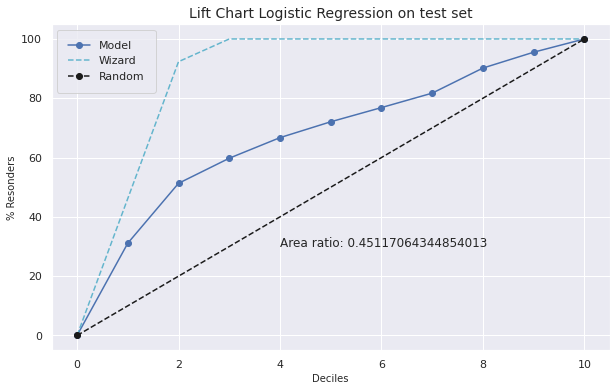

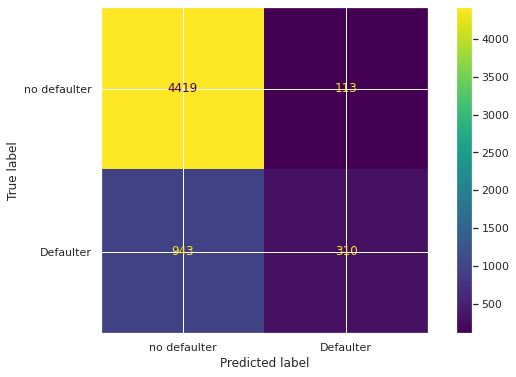

In [79]:
train_pcg_Logistic = decile_table(y, train_proba_Logistic[:, 1], labels=False)
test_pcg_Logistic = decile_table(y_test, test_proba_Logistic[:, 1], labels=False)
error_rate_train_Logistic = 1 - accuracy_score(y, train_pred_Logistic)
area_ratio_train_Logistic = area_ratio(train_pcg_Logistic)
error_rate_test_Logistic = 1 - accuracy_score(y_test, test_pred_Logistic)
area_ratio_test_Logistic = area_ratio(test_pcg_Logistic)
y_pred_label_Logistic = test_proba_Logistic.argmax(1)
print(f"Logistic Regression error rate on train set (training): {error_rate_train_Logistic} | area ratio on train set (training): {area_ratio_train_Logistic}\n")
print(f"Logistic Regression error rate on test (valid) set: {error_rate_test_Logistic} | area ratio on test (valid) set: {area_ratio_test_Logistic} \n")
plot_lift_chart(test_pcg_Logistic, area_ratio_test_Logistic, title='Lift Chart Logistic Regression on test set')
cm = confusion_matrix(y_test, y_pred_label_Logistic, labels=Logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

#### Avec CV

Error rate CV score: 0.18549565055285025 | Area ratio score: 0.4624729525222122

Error rate test (validation) score: 0.18305963699222128 | Area ratio score: 0.45055295755725794




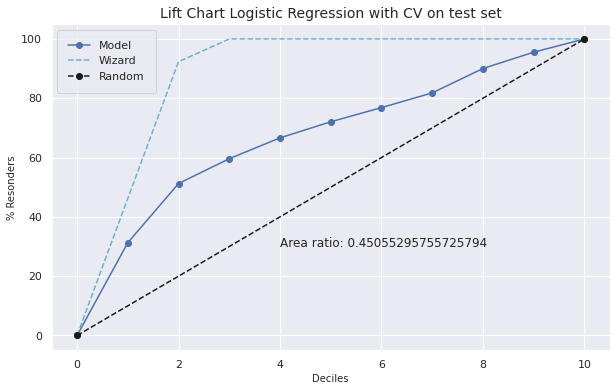

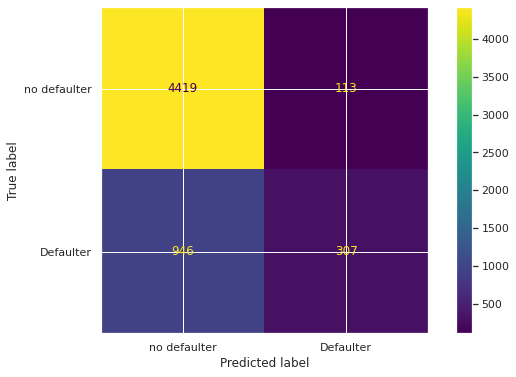

In [80]:
y_pred_label_Logistic_cv = test_proba_Logistic_cv.argmax(1)
test_pcg_Logistic_cv = decile_table(y_test, test_proba_Logistic_cv[:, 1], labels=False)
test_area_ratio_Logistic_cv = area_ratio(test_pcg_Logistic_cv)
print(f"Error rate CV score: {np.mean(np.array(error_rate_valids_Logistic_cv))} | Area ratio score: {np.mean(np.array(area_ratio_valids_Logistic_cv))}\n")
print(f"Error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_Logistic_cv)} | Area ratio score: {test_area_ratio_Logistic_cv}")
plot_lift_chart(test_pcg_Logistic_cv, test_area_ratio_Logistic_cv, title='Lift Chart Logistic Regression with CV on test set')
cm = confusion_matrix(y_test, y_pred_label_Logistic_cv, labels=Logistic_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()
print("\n")

## Random Forest

#### Sans CV

Random Forest error rate on train set (training): 0.1624168035266661 | area ratio on train set (training): 0.6094842876744422

Random Forest error rate on test (valid) set: 0.17614520311149529 | area ratio on test (valid) set: 0.5546896514449989 



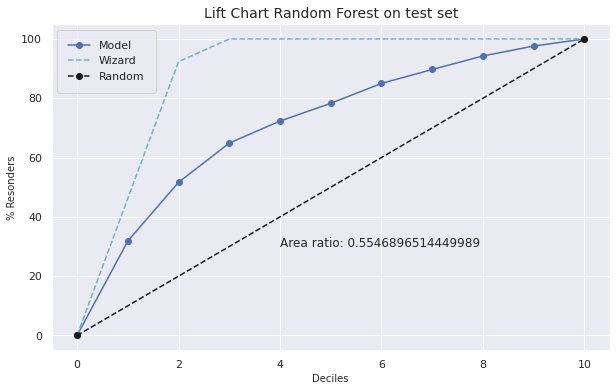

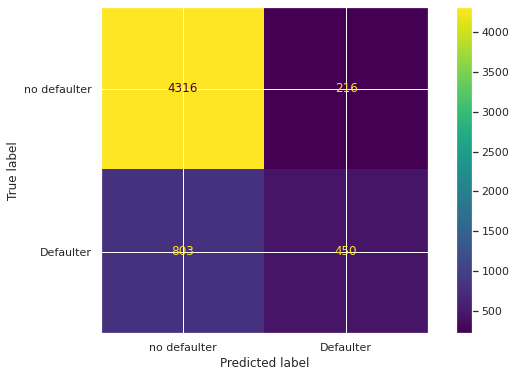

In [81]:
train_pcg_RF = decile_table(y, train_proba_RF[:, 1], labels=False)
test_pcg_RF = decile_table(y_test, test_proba_RF[:, 1], labels=False)
error_rate_train_RF = 1 - accuracy_score(y, train_pred_RF)
area_ratio_train_RF = area_ratio(train_pcg_RF)
error_rate_test_RF = 1 - accuracy_score(y_test, test_pred_RF)
area_ratio_test_RF = area_ratio(test_pcg_RF)
y_pred_label_RF = test_proba_RF.argmax(1)
print(f"Random Forest error rate on train set (training): {error_rate_train_RF} | area ratio on train set (training): {area_ratio_train_RF}\n")
print(f"Random Forest error rate on test (valid) set: {error_rate_test_RF} | area ratio on test (valid) set: {area_ratio_test_RF} \n")
plot_lift_chart(test_pcg_RF, area_ratio_test_RF, title='Lift Chart Random Forest on test set')
cm = confusion_matrix(y_test, y_pred_label_RF, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

#### Avec CV

Error rate CV score: 0.17330774666527443 | Area ratio score: 0.5580565769963461

Error rate test (validation) score: 0.17510803802938635 | Area ratio score: 0.5583854720278368




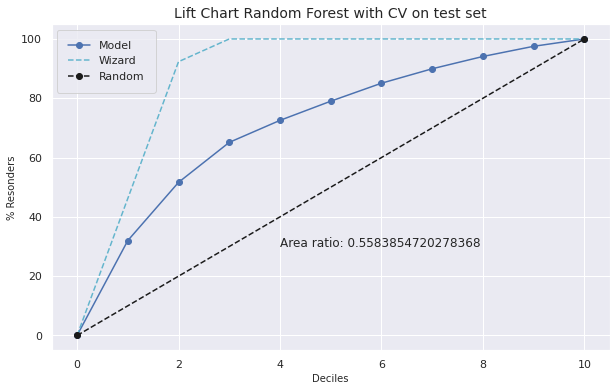

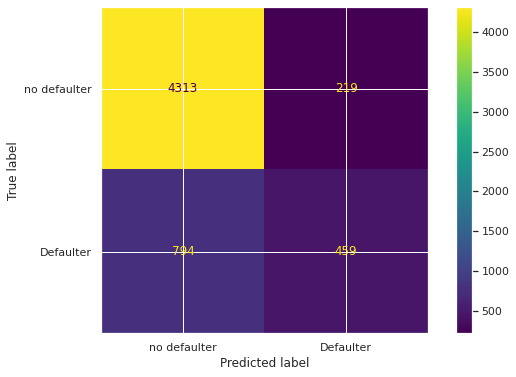

In [82]:
y_pred_label_RF_CV = test_proba_RF_CV.argmax(1)
test_pcg_RF_CV = decile_table(y_test, test_proba_RF_CV[:, 1], labels=False)
test_area_ratio_RF_CV = area_ratio(test_pcg_RF_CV)
print(f"Error rate CV score: {np.mean(np.array(error_rate_valids_RF_CV))} | Area ratio score: {np.mean(np.array(area_ratio_valids_RF_CV))}\n")
print(f"Error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_RF_CV)} | Area ratio score: {test_area_ratio_RF_CV}")
plot_lift_chart(test_pcg_RF_CV, test_area_ratio_RF_CV, title='Lift Chart Random Forest with CV on test set')
cm = confusion_matrix(y_test, y_pred_label_RF_CV, labels=RF_CV.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()
print("\n")


## Linear Discriminant Analysis

#### Sans CV

Linear Discriminant Analysis error rate on train set (training): 0.18247039502117723 | area ratio on train set (training): 0.4597750564418347

Linear Discriminant Analysis error rate on test (valid) set: 0.17614520311149529 | area ratio on test (valid) set: 0.44171490192949614 



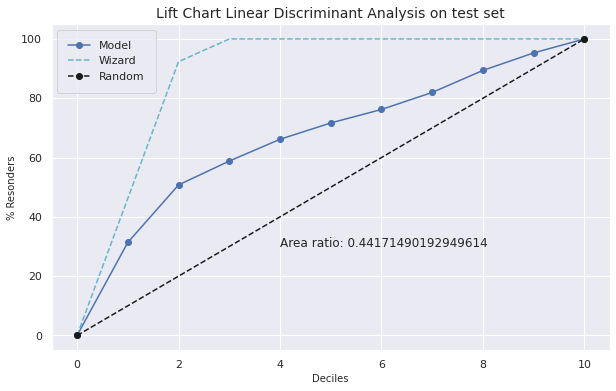

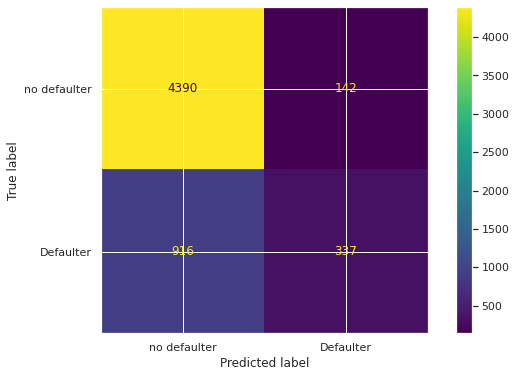

In [83]:
train_pcg_LDA = decile_table(y, train_proba_LDA[:, 1], labels=False)
test_pcg_LDA = decile_table(y_test, test_proba_LDA[:, 1], labels=False)
error_rate_train_LDA = 1 - accuracy_score(y, train_pred_LDA)
area_ratio_train_LDA = area_ratio(train_pcg_LDA)
error_rate_test_LDA = 1 - accuracy_score(y_test, test_pred_RF)
area_ratio_test_LDA = area_ratio(test_pcg_LDA)
y_pred_label_LDA = test_proba_LDA.argmax(1)
print(f"Linear Discriminant Analysis error rate on train set (training): {error_rate_train_LDA} | area ratio on train set (training): {area_ratio_train_LDA}\n")
print(f"Linear Discriminant Analysis error rate on test (valid) set: {error_rate_test_LDA} | area ratio on test (valid) set: {area_ratio_test_LDA} \n")
plot_lift_chart(test_pcg_LDA, area_ratio_test_LDA, title='Lift Chart Linear Discriminant Analysis on test set')
cm = confusion_matrix(y_test, y_pred_label_LDA, labels=LDA.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

#### Avec CV

Error rate CV score: 0.18320499215550973 | Area ratio score: 0.4558497435326355

Error rate test (validation) score: 0.1828867761452031 | Area ratio score: 0.4419207972265903




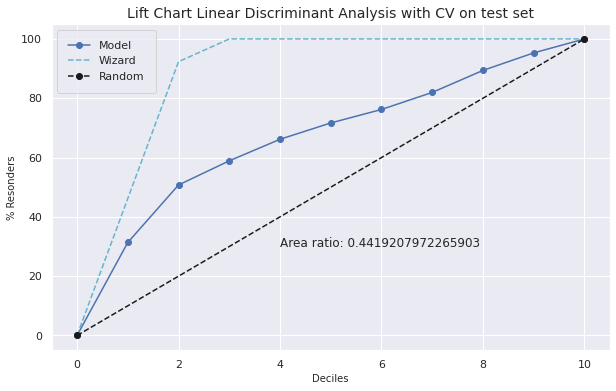

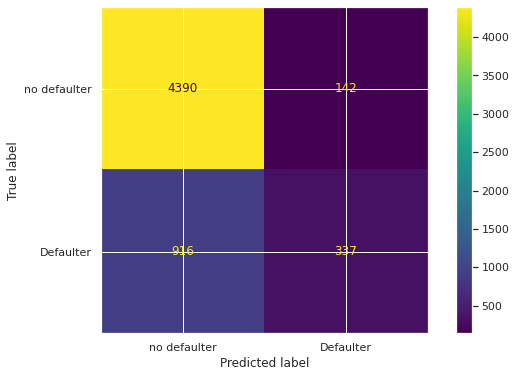

In [84]:
y_pred_label_LDA_CV = test_proba_LDA_CV.argmax(1)
test_pcg_LDA_CV = decile_table(y_test, test_proba_LDA_CV[:, 1], labels=False)
test_area_ratio_LDA_CV = area_ratio(test_pcg_LDA_CV)
print(f"Error rate CV score: {np.mean(np.array(error_rate_valids_LDA_CV))} | Area ratio score: {np.mean(np.array(area_ratio_valids_LDA_CV))}\n")
print(f"Error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_LDA_CV)} | Area ratio score: {test_area_ratio_LDA_CV}")
plot_lift_chart(test_pcg_LDA_CV, test_area_ratio_LDA_CV, title='Lift Chart Linear Discriminant Analysis with CV on test set')
cm = confusion_matrix(y_test, y_pred_label_LDA_CV, labels=LDA_CV.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()
print("\n")

## Neural Network MLP

#### Sans CV

Neural Network error rate on train set (training): 0.16505315930503928 | Neural Network area ratio on train set (training): 0.6190349926503336

Neural Network error rate on test (valid) set: 0.17873811581676746 | Neural Network area ratio on test (valid) set: 0.5325095805655431 



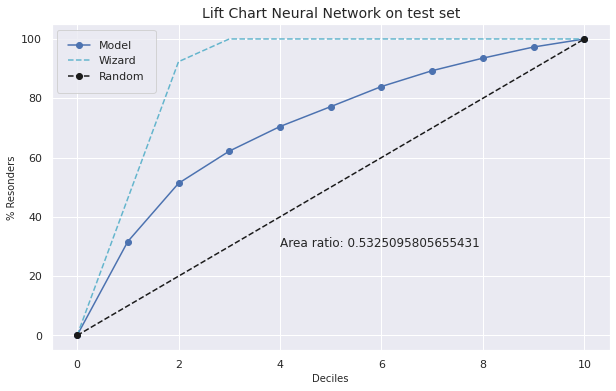

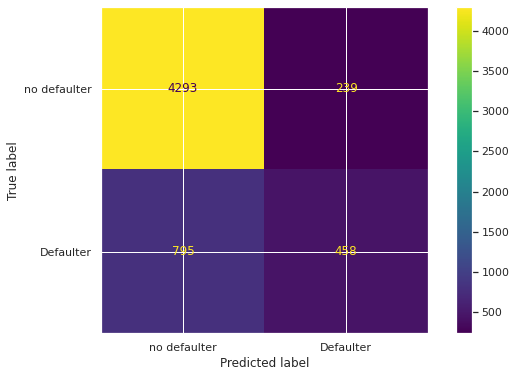

In [85]:
# Area ratio & accuracy on the train data
train_pcg_nnet = decile_table(y, train_proba_nnet[:, 1], labels=False)
area_ratio_train_nnet = area_ratio(train_pcg_nnet)
error_rate_train_nnet = 1 - accuracy_score(y, train_pred_nnet)

# Predict proba & labels on the test data
test_pred_nnet = nnet.predict(nnet_article_test)
test_proba_nnet = nnet.predict_proba(nnet_article_test)

# Area ratio & accuracy on the test data
test_pcg_nnet = decile_table(y_test, test_proba_nnet[:, 1], labels=False)
error_rate_test_nnet = 1 - accuracy_score(y_test, test_pred_nnet)
area_ratio_test_nnet = area_ratio(test_pcg_nnet)

print(f"Neural Network error rate on train set (training): {error_rate_train_nnet} | Neural Network area ratio on train set (training): {area_ratio_train_nnet}\n")
print(f"Neural Network error rate on test (valid) set: {error_rate_test_nnet} | Neural Network area ratio on test (valid) set: {area_ratio_test_nnet} \n")

# Plot lift chart
plot_lift_chart(test_pcg_nnet, area_ratio_test_nnet, title='Lift Chart Neural Network on test set')

# Confusion matrix
cm = confusion_matrix(y_test, test_pred_nnet, labels=nnet.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['no defaulter', 'Defaulter'])
disp.plot()

## avec CV

Neural Network error rate CV score: 0.17451785665251812 | KNN area ratio score: 0.5512776187605979

Neural Network Forest error rate test (validation) score: 0.17562662057044076 | KNN area ratio score: 0.5548955467420931




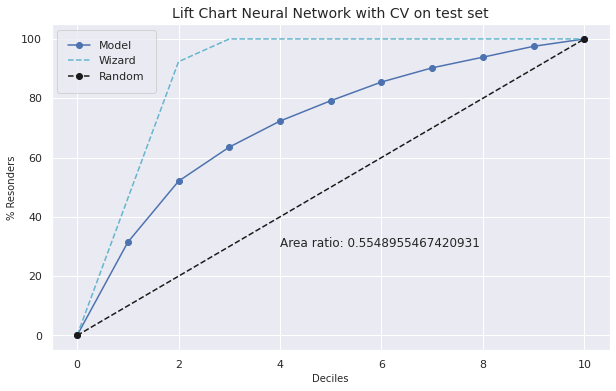

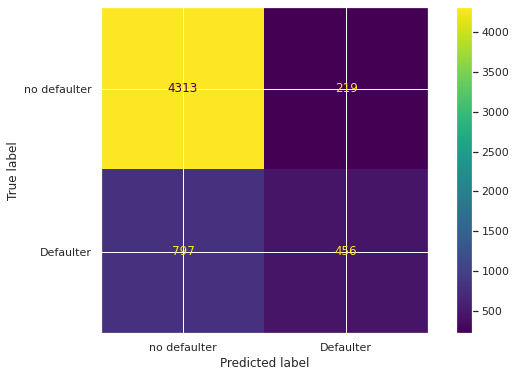

In [86]:
# Label predictions on test data
y_pred_label_nnet_CV = test_proba_nnet_CV.argmax(1)
# Area ratio on test data
test_pcg_nnet_CV = decile_table(y_test, test_proba_nnet_CV[:,1], labels=False)
test_area_ratio_nnet_CV = area_ratio(test_pcg_nnet_CV)
print(f"Neural Network error rate CV score: {np.mean(np.array(error_rate_valids_nnet_CV))} | KNN area ratio score: {np.mean(np.array(area_ratio_valids_nnet_CV))}\n")
print(f"Neural Network Forest error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_nnet_CV)} | KNN area ratio score: {test_area_ratio_nnet_CV}")
# Plot lift chart
plot_lift_chart(test_pcg_nnet_CV, test_area_ratio_nnet_CV, title='Lift Chart Neural Network with CV on test set')
print("\n")
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_label_nnet_CV, labels=nnet.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['no defaulter', 'Defaulter'])
disp.plot()

## Desicion Tree

#### Sans CV

Desicion Tree error rate on train set (training): 0.16310830668164922 | area ratio on train set (training): 0.5804305797612582

Desicion Tree error rate on test (valid) set: 0.18755401901469315 | area ratio on test (valid) set: 0.4378131860495638 



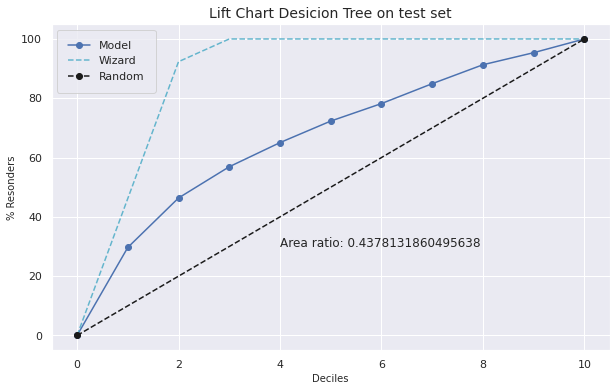

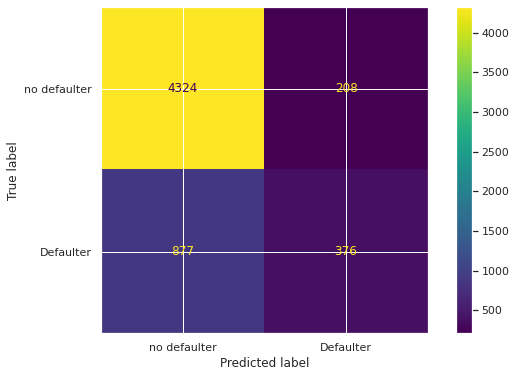

In [87]:
train_pcg_DT = decile_table(y, train_proba_DT[:, 1], labels=False)
test_pcg_DT = decile_table(y_test, test_proba_DT[:, 1], labels=False)
error_rate_train_DT = 1 - accuracy_score(y, train_pred_DT)
area_ratio_train_DT = area_ratio(train_pcg_DT)
error_rate_test_DT = 1 - accuracy_score(y_test, test_pred_DT)
area_ratio_test_DT = area_ratio(test_pcg_DT)
y_pred_label_DT = test_proba_DT.argmax(1)
print(f"Desicion Tree error rate on train set (training): {error_rate_train_DT} | area ratio on train set (training): {area_ratio_train_DT}\n")
print(f"Desicion Tree error rate on test (valid) set: {error_rate_test_DT} | area ratio on test (valid) set: {area_ratio_test_DT} \n")
plot_lift_chart(test_pcg_DT, area_ratio_test_DT, title='Lift Chart Desicion Tree on test set')
cm = confusion_matrix(y_test, y_pred_label_DT, labels=DT.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

#### avec CV

Error rate CV score: 0.1776727912655771 | Area ratio score: 0.5109855169842538

Error rate test (validation) score: 0.1759723422644771 | Area ratio score: 0.5298329417033203




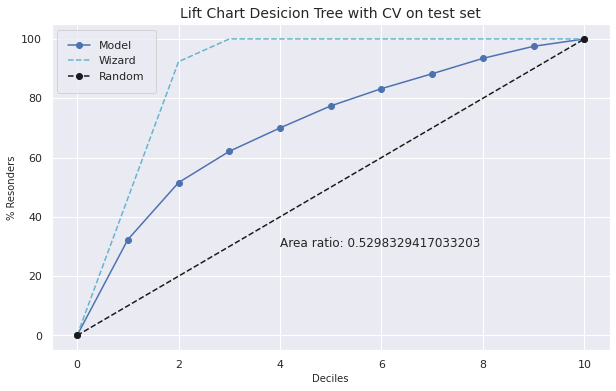

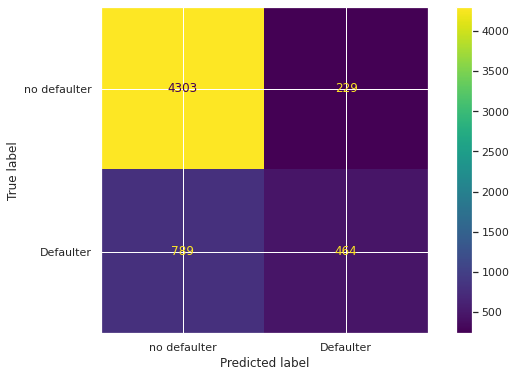

In [88]:
y_pred_label_DT_cv = test_proba_DT_cv.argmax(1)
test_pcg_DT_cv = decile_table(y_test, test_proba_DT_cv[:, 1], labels=False)
test_area_ratio_DT_cv = area_ratio(test_pcg_DT_cv)
print(f"Error rate CV score: {np.mean(np.array(error_rate_valids_DT_cv))} | Area ratio score: {np.mean(np.array(area_ratio_valids_DT_cv))}\n")
print(f"Error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_DT_cv)} | Area ratio score: {test_area_ratio_DT_cv}")
plot_lift_chart(test_pcg_DT_cv, test_area_ratio_DT_cv, title='Lift Chart Desicion Tree with CV on test set')
cm = confusion_matrix(y_test, y_pred_label_DT_cv, labels=DT_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()
print("\n")

## Naive Bayes

#### Sans CV

Naive Bayes error rate on train set (training): 0.24137782003630393 | area ratio on train set (training): 0.48010183986222266

Naive Bayes rate on test (valid) set: 0.2416594641313743 | area ratio on test (valid) set: 0.4645178060826617 



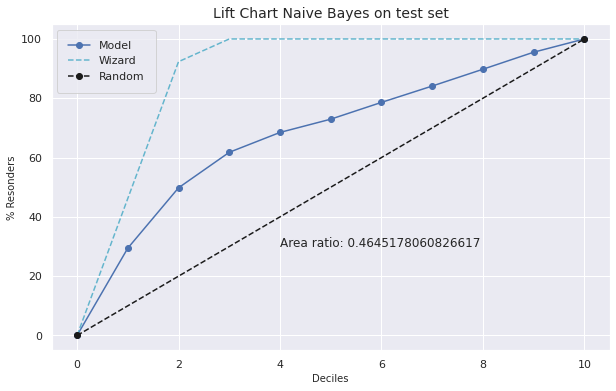

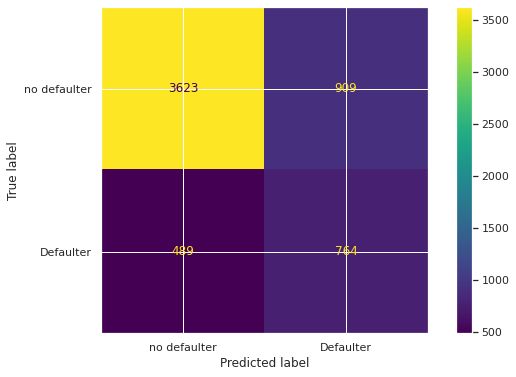

In [89]:
train_pcg_NB = decile_table(y, train_proba_NB[:, 1], labels=False)
test_pcg_NB = decile_table(y_test, test_proba_NB[:, 1], labels=False)
error_rate_train_NB = 1 - accuracy_score(y, train_pred_NB)
area_ratio_train_NB = area_ratio(train_pcg_NB)
error_rate_test_NB = 1 - accuracy_score(y_test, test_pred_NB)
area_ratio_test_NB = area_ratio(test_pcg_NB)
y_pred_label_NB = test_proba_NB.argmax(1)
print(f"Naive Bayes error rate on train set (training): {error_rate_train_NB} | area ratio on train set (training): {area_ratio_train_NB}\n")
print(f"Naive Bayes rate on test (valid) set: {error_rate_test_NB} | area ratio on test (valid) set: {area_ratio_test_NB} \n")
plot_lift_chart(test_pcg_NB, area_ratio_test_NB, title='Lift Chart Naive Bayes on test set')
cm = confusion_matrix(y_test, y_pred_label_NB, labels=NB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()

#### Avec CV

Error rate CV score: 0.2630720551779893 | Area ratio score: 0.47797336561395215

Error rate test (validation) score: 0.24321521175453764 | Area ratio score: 0.46780440976252524




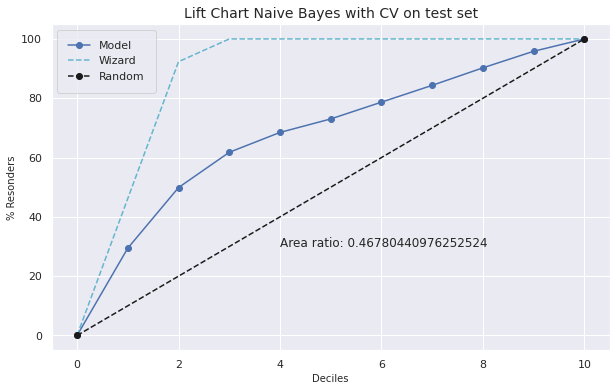

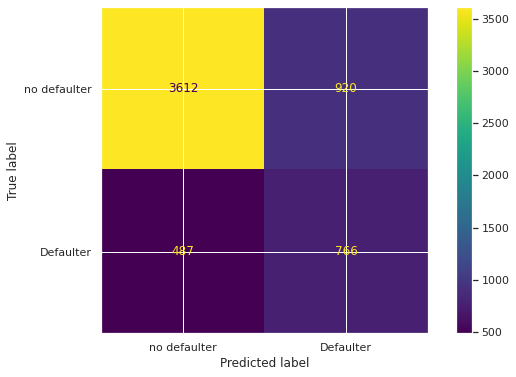

In [90]:
y_pred_label_NB_cv = test_proba_NB_cv.argmax(1)
test_pcg_NB_cv = decile_table(y_test, test_proba_NB_cv[:, 1], labels=False)
test_area_ratio_NB_cv = area_ratio(test_pcg_NB_cv)
print(f"Error rate CV score: {np.mean(np.array(error_rate_valids_NB_cv))} | Area ratio score: {np.mean(np.array(area_ratio_valids_NB_cv))}\n")
print(f"Error rate test (validation) score: {1 - accuracy_score(y_test, y_pred_label_NB_cv)} | Area ratio score: {test_area_ratio_NB_cv}")
plot_lift_chart(test_pcg_NB_cv, test_area_ratio_NB_cv, title='Lift Chart Naive Bayes with CV on test set')
cm = confusion_matrix(y_test, y_pred_label_NB_cv, labels=NB_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no defaulter', 'Defaulter'])
disp.plot()
print("\n")

## Benchmarking

In [91]:
table={'Error rate : training : without cv':[error_rate_train_knn,error_rate_train_xgb,error_rate_train_Logistic,error_rate_train_RF,error_rate_train_LDA,error_rate_train_nnet,error_rate_train_DT,error_rate_train_NB],
       'Area ratio : training : without cv':[area_ratio_train_knn,area_ratio_train_xgb,area_ratio_train_Logistic,area_ratio_train_RF,area_ratio_train_LDA,area_ratio_train_nnet,area_ratio_train_DT,area_ratio_train_NB],
        'Error rate : validation : without cv':[error_rate_test_knn,error_rate_test_xgb,error_rate_test_Logistic,error_rate_test_RF,error_rate_test_LDA,error_rate_test_nnet,error_rate_test_DT,error_rate_test_NB],
       'Area ratio : validation : without cv':[area_ratio_test_knn,area_ratio_test_xgb,area_ratio_test_Logistic,area_ratio_test_RF,area_ratio_test_LDA,area_ratio_test_nnet,area_ratio_test_DT,area_ratio_test_NB],
        'Error rate : training : with cv':[np.mean(np.array(error_rate_valids_knn_cv)),np.mean(np.array(error_rate_valids_xgb_cv)),np.mean(np.array(error_rate_valids_Logistic_cv)),np.mean(np.array(error_rate_valids_RF_CV)),np.mean(np.array(error_rate_valids_LDA_CV)),np.mean(np.array(error_rate_valids_nnet_CV)),np.mean(np.array(error_rate_valids_DT_cv)),np.mean(np.array(error_rate_valids_NB_cv))],
       'Area ratio : training : with cv':[np.mean(np.array(area_ratio_valids_knn_cv)),np.mean(np.array(area_ratio_valids_xgb_cv)),np.mean(np.array(area_ratio_valids_Logistic_cv)),np.mean(np.array(area_ratio_valids_RF_CV)),np.mean(np.array(area_ratio_valids_LDA_CV)),np.mean(np.array(area_ratio_valids_nnet_CV)),np.mean(np.array(area_ratio_valids_DT_cv)),np.mean(np.array(area_ratio_valids_NB_cv))],
       'Error rate : validation : with cv':[1 - accuracy_score(y_test, y_pred_label_knn_cv),1 - accuracy_score(y_test, y_pred_label_xgb_cv),1 - accuracy_score(y_test, y_pred_label_Logistic_cv),1 - accuracy_score(y_test, y_pred_label_RF_CV),1 - accuracy_score(y_test, y_pred_label_LDA_CV),1 - accuracy_score(y_test, y_pred_label_nnet_CV),1 - accuracy_score(y_test, y_pred_label_DT_cv),1 - accuracy_score(y_test, y_pred_label_NB_cv)],
       'Area ratio : validation : with cv':[test_area_ratio_knn_cv,test_area_ratio_xgb_cv,test_area_ratio_Logistic_cv,test_area_ratio_RF_CV,test_area_ratio_LDA_CV,test_area_ratio_nnet_CV,test_area_ratio_DT_cv,test_area_ratio_NB_cv]}
pd.DataFrame(table,index=["KNN","XGBoost","Linear Regression","Random Forest","Linear Discriminant Analysis","Neural Network MLP","Desicion Tree","Naive Bayes"])

,Error rate : training : without cv,Area ratio : training : without cv,Error rate : validation : without cv,Area ratio : validation : without cv,Error rate : training : with cv,Area ratio : training : with cv,Error rate : validation : with cv,Area ratio : validation : with cv
KNN,0.167992,0.698718,0.187554,0.437813,0.186706,0.472174,0.182887,0.454452
XGBoost,0.173524,0.573907,0.177182,0.550376,0.172270,0.555080,0.175972,0.549761
Linear Regression,0.185582,0.465881,0.182541,0.451171,0.185496,0.462473,0.183060,0.450553
Random Forest,0.162417,0.609484,0.176145,0.554690,0.173308,0.558057,0.175108,0.558385
Linear Discriminant Analysis,0.182470,0.459775,0.176145,0.441715,0.183205,0.455850,0.182887,0.441921
Neural Network MLP,0.165053,0.619035,0.178738,0.532510,0.174518,0.551278,0.175627,0.554896
Desicion Tree,0.163108,0.580431,0.187554,0.437813,0.177673,0.510986,0.175972,0.529833
Naive Bayes,0.241378,0.480102,0.241659,0.464518,0.263072,0.477973,0.243215,0.467804


 #### VI. Deploiement (optionnel)